# 解析ハンズオンscRNA-seq with python: 1. Getting started with scanpy

2024年12月12日

微生物病研究所　神元健児

## はじめに
### 目的
シングルセルRNA-sequencing (scRNA-seq）データ解析の基礎の習得を目指します。
- 10x Genomics社のプラットフォームで計測されたデータを例に、scRNA-seqデータの読み込みから基本的な前処理、可視化、変動している遺伝子の解析などの基本的な解析を行います。
- Google Colabの環境を用いてPythonを利用した解析を行い、そのためのソフトウェア(Scanpy)のインストールや基本的な使用法を習得することを目指します。
- Python やJupyter notebookなどの基本的な概念については午前中に行われる別のハンズオンで説明を行うので、その詳細な説明は本ハンズオンでは省きますが、質問などがあればはその都度聞いてください。
- scRNA-seqの原理や各操作の必要性などは適宜別のスライドを用いて説明します。

### 本ノートブックについて
- Scanpyを使用したscRNA-seqの解析方法を取得します。[Scanpy とは？](https://scanpy.readthedocs.io/en/stable/index.html)=>PythonでのscRNA-seqの解析ソフトウェアです。データの前処理から下流解析まで様々な解析が行えます。
- Scanpy の[チュートリアルの資料](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html)をもとに作成されています。
- PBMCデータのSeurat (RのscRNA-seq用の解析パッケージ)での解析をScanpyで再現するようになっています。

### 本ノートブックで扱わないこと
本ノートブックでは基礎的なデータの取り扱いに焦点をあてるため、発展的な内容は扱いません。
- Pseudotime解析, Trajectory解析　（＝＞スライドで説明、時間があれば別のノートブックでハンズオン)
- AI解析　（要望があれば次回以降の講習会で扱います）
- 空間とランスクリプトーム解析　（要望があれば次回以降の講習会で扱います）
- 遺伝子ネットワーク解析　（要望があれば次回以降の講習会で扱います）
- 細胞間相互作用解析　（要望があれば次回以降の講習会で扱います）



# Google Colabのフォルダの準備

作業した内容を自分のgoogle driveフォルダに直接保存したり、読み込んだりできるようにします。
以下のコードを実行すると別画面で認証を求められるので、許可を行なってください。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 現在いる場所の確認
!pwd

/content


Google Driveに`scRNAseq_hands-on`というフォルダ名でファイルを保存するとします。
その場合は以下のコマンドでそのフォルダに”移動”できます

In [3]:
cd /content/drive/MyDrive/scRNAseq_hands-on/

/content/drive/MyDrive/scRNAseq_hands-on


In [84]:
# 現在いる場所の確認
!pwd

/content/drive/MyDrive/scRNAseq_hands-on


# Scanpy のインストール

Google Colabの環境にScanpyをインストールします。以下のコマンドで全て必要なものがインストールされます。

In [5]:
!pip install scanpy

In [6]:
# 関連するパッケージのインストール
!pip install python-igraph fa2-modified

これはPythonやColabの解析と直接関係はありませんが、後にファイルを確認するときに便利なtreeというコマンドをインストールしておきます。
Google colab ではなく、WindowsやMacで以下のコマンドを実行するとエラーになるのでその場合は実行しなくて良いです。

In [7]:
# Linux command のインストール
!apt install  tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# PBMCの解析チュートリアル

R言語を用いたscRNA-seq解析のパッケージ、Seuratは現在最も広く使用されるscRNA-seq解析ソフトの一つです。Seuratでの解析チュートリアルではPBMCデータを使用します。このPBMCデータセットは2700個程度の小規模のデータですが、遺伝子発現パターンの異なるたくさんの細胞種を含み、細胞種や遺伝子発現のパターンも知られていて検証ができるため、scRNA-seq解析の基本を習得するためや新しい解析方の検証データとして有用です。

以下のノートブックではSeuratのPBMCのチュートリアルをscanpyを利用して再現した、scanpyの公式チュートリアルを利用します。ScanpyではSeuratとは必ずしも利用可能な関数が同じではなので、scanpy解析ではいくつか追加された解析があります。また、本ハンズオンではGoogle Colabでの使用のためや説明のために加筆・修正してあります。


# 10x Genomics でのscRNA-seqについて
- 10x GenomicsはscRNA-seq, scATAC-seq, Spatial transcriptomeなどの計測プラットフォームを提供する会社で、現在最も広く利用されているscRNA-seqは10x Genomics社のものです。
https://www.10xgenomics.com/
大阪大学微生物病研究所ゲノム解析室でも10x Genomicsによる計測が多く行われ、scRNA-seqを計画する時のファーストチョイスになるかと思います。

- NGSで測定したFastqファイルは Cell-rangerというソフトウェアで処理され、遺伝子と細胞の表データ（Gene expression matrix)に変換されます。https://www.10xgenomics.com/support/software/cell-ranger/latest

- 受託解析を行なった場合でも、cell-rangerの出力を渡されることが多いと思いますので、このファイルについての概要と、そのファイルをpythonで読み込む方法について簡単に説明します。https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-ct


# データのダウンロード

本ハンズオンでは10x Genomicsのfiltered_feature_bc_matrixデータをダウンロードして解析します。

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

以下のコマンドではdata というフォルダを作成し、その中にpbmcのscRNA-seqデータを直接ダウンロードし、解凍します。別途ダウンロードしたデータをGoogle drive内のフォルダに手動で配置しても構いません。

In [8]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘data’: File exists
--2024-12-11 13:22:17--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2024-12-11 13:22:17--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  39.6MB/s    in 0.2s    

2024-12-11 13:22:17

In [9]:
# data フォルダ内のファイルを確認
!tree data

data
├── filtered_gene_bc_matrices
│   └── hg19
│       ├── barcodes.tsv
│       ├── genes.tsv
│       └── matrix.mtx
└── pbmc3k_filtered_gene_bc_matrices.tar.gz

2 directories, 4 files


filtered_gene_bc_matrices/hg19　というフォルダの中に、barcodes.tsv, genes.tsv, matrix.mtxという３つのファイルが作成されています。これがscRNA-seqのデータとなります。

# Scanpyを用いたscRNA-sqのデータ処理

## 1. パッケージのインポートと設定

In [10]:
# パッケージのインポート
# Scanpy と Pandasというpythonパッケージを読み込みます。pandasは表データを取り扱うための汎用パッケージです。
import pandas as pd
import scanpy as sc

In [11]:
# エラーメッセージや図の解像度などの表示設定
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13



## 2. ファイルの読み込みとAnnDataオブジェクトの作成

Scanpyでは読み込んだ複雑なデータを効率的に扱うためにAnnDataというデータ形式を採用しています。
AnnDataは色々なファイル形式から作成できますが、今回は前述の`barcodes.tsv, genes.tsv, matrix.mtx`の３つのファイルから作成するため、このファイルがあるフォルダを指定して`sc.read_10x_mtx()`関数で読み込みます。


Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.

In [12]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [13]:
# AnnDataをそのまま実行すると、内部の情報の概要が示されます。
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [14]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [15]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## 3. Preprocessing

多くの細胞で発現されている遺伝子について可視化

normalizing counts per cell
    finished (0:00:00)


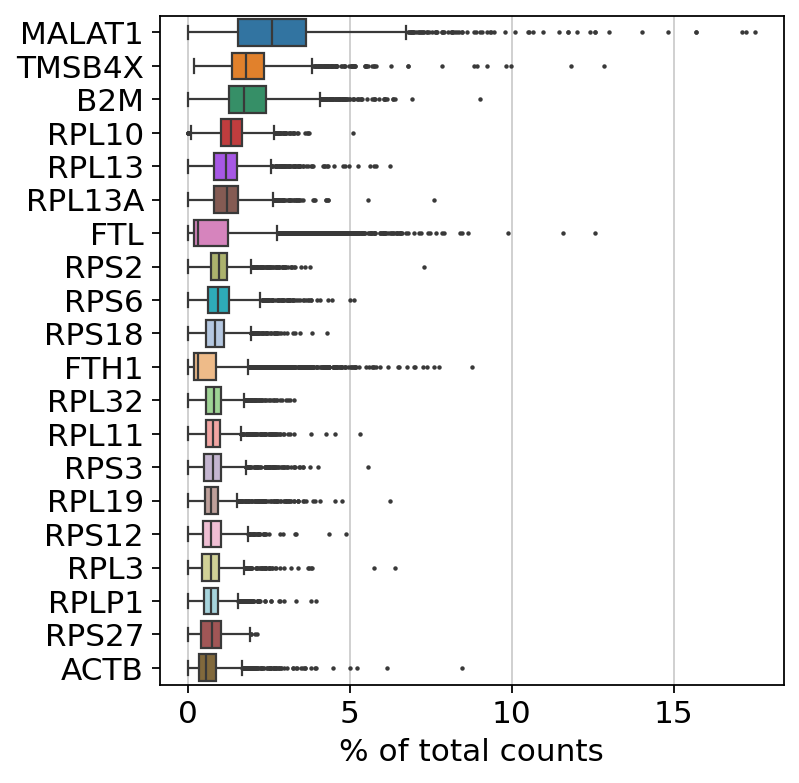

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

細胞と遺伝子のフィルタリング。
遺伝子がほとんど検出されていない細胞やほとんどの細胞で検出されていない遺伝子を除く

Basic filtering:

In [17]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells



次にミトコンドリア遺伝子のカウントに応じたフィルタリングを行います。
ミトコンドリア遺伝子のカウントの割合が異常に大きいもの（核ゲノム由来の遺伝子の割合が少ないもの）は、１細胞seq実験がうまくいっていない細胞のデータ（低品質データ）なので除きます。

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

ところで、遺伝子の情報は.varというところに保存されている

In [18]:
adata.var

gene_ids  n_cells
AL627309.1     ENSG00000237683        9
AP006222.2     ENSG00000228463        3
RP11-206L10.2  ENSG00000228327        5
RP11-206L10.9  ENSG00000237491        3
LINC00115      ENSG00000225880       18
...                        ...      ...
AC145212.1     ENSG00000215750       16
AL592183.1     ENSG00000220023      323
AL354822.1     ENSG00000215615        8
PNRC2-1        ENSG00000215700      110
SRSF10-1       ENSG00000215699       69

[13714 rows x 2 columns]

In [19]:
# リストとして遺伝子名を得る. 例として最初の十個を表示
adata.var.index.to_list()[:10]

['AL627309.1',
 'AP006222.2',
 'RP11-206L10.2',
 'RP11-206L10.9',
 'LINC00115',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'RP11-54O7.17',
 'HES4']

In [20]:
# このデータではMT- が遺伝子名の最初に着くものがミトコンドリア遺伝子。
[i for i in adata.var.index.to_list() if i.startswith("MT-")]

['MT-ND1',
 'MT-ND2',
 'MT-CO1',
 'MT-CO2',
 'MT-ATP8',
 'MT-ATP6',
 'MT-CO3',
 'MT-ND3',
 'MT-ND4L',
 'MT-ND4',
 'MT-ND5',
 'MT-ND6',
 'MT-CYB']

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [21]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [22]:
# 追加された遺伝子情報をチェック
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
AL627309.1     ENSG00000237683        9  False                  9   
AP006222.2     ENSG00000228463        3  False                  3   
RP11-206L10.2  ENSG00000228327        5  False                  5   
RP11-206L10.9  ENSG00000237491        3  False                  3   
LINC00115      ENSG00000225880       18  False                 18   
...                        ...      ...    ...                ...   
AC145212.1     ENSG00000215750       16  False                 16   
AL592183.1     ENSG00000220023      323  False                323   
AL354822.1     ENSG00000215615        8  False                  8   
PNRC2-1        ENSG00000215700      110  False                110   
SRSF10-1       ENSG00000215699       69  False                 69   

               mean_counts  pct_dropout_by_counts  total_counts  
AL627309.1        0.003333              99.666667           9.0  
AP006222.2        0.001111              99.888889           3.0  
RP11-206L10.2     0.001852              99.814815           5.0  
RP11-206L10.9     0.001111              99.888889           3.0  
LINC00115         0.006667              99.333333          18.0  
...                    ...                    ...           ...  
AC145212.1        0.006667              99.407407          18.0  
AL592183.1        0.134815              88.037037         364.0  
AL354822.1        0.002963              99.703704           8.0  
PNRC2-1           0.042963              95.925926         116.0  
SRSF10-1          0.025926              97.444444          70.0  

[13714 rows x 7 columns]

`sc.pl.violin`や`sc.pl.scatter`を用いて計算した上記の情報を可視化

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

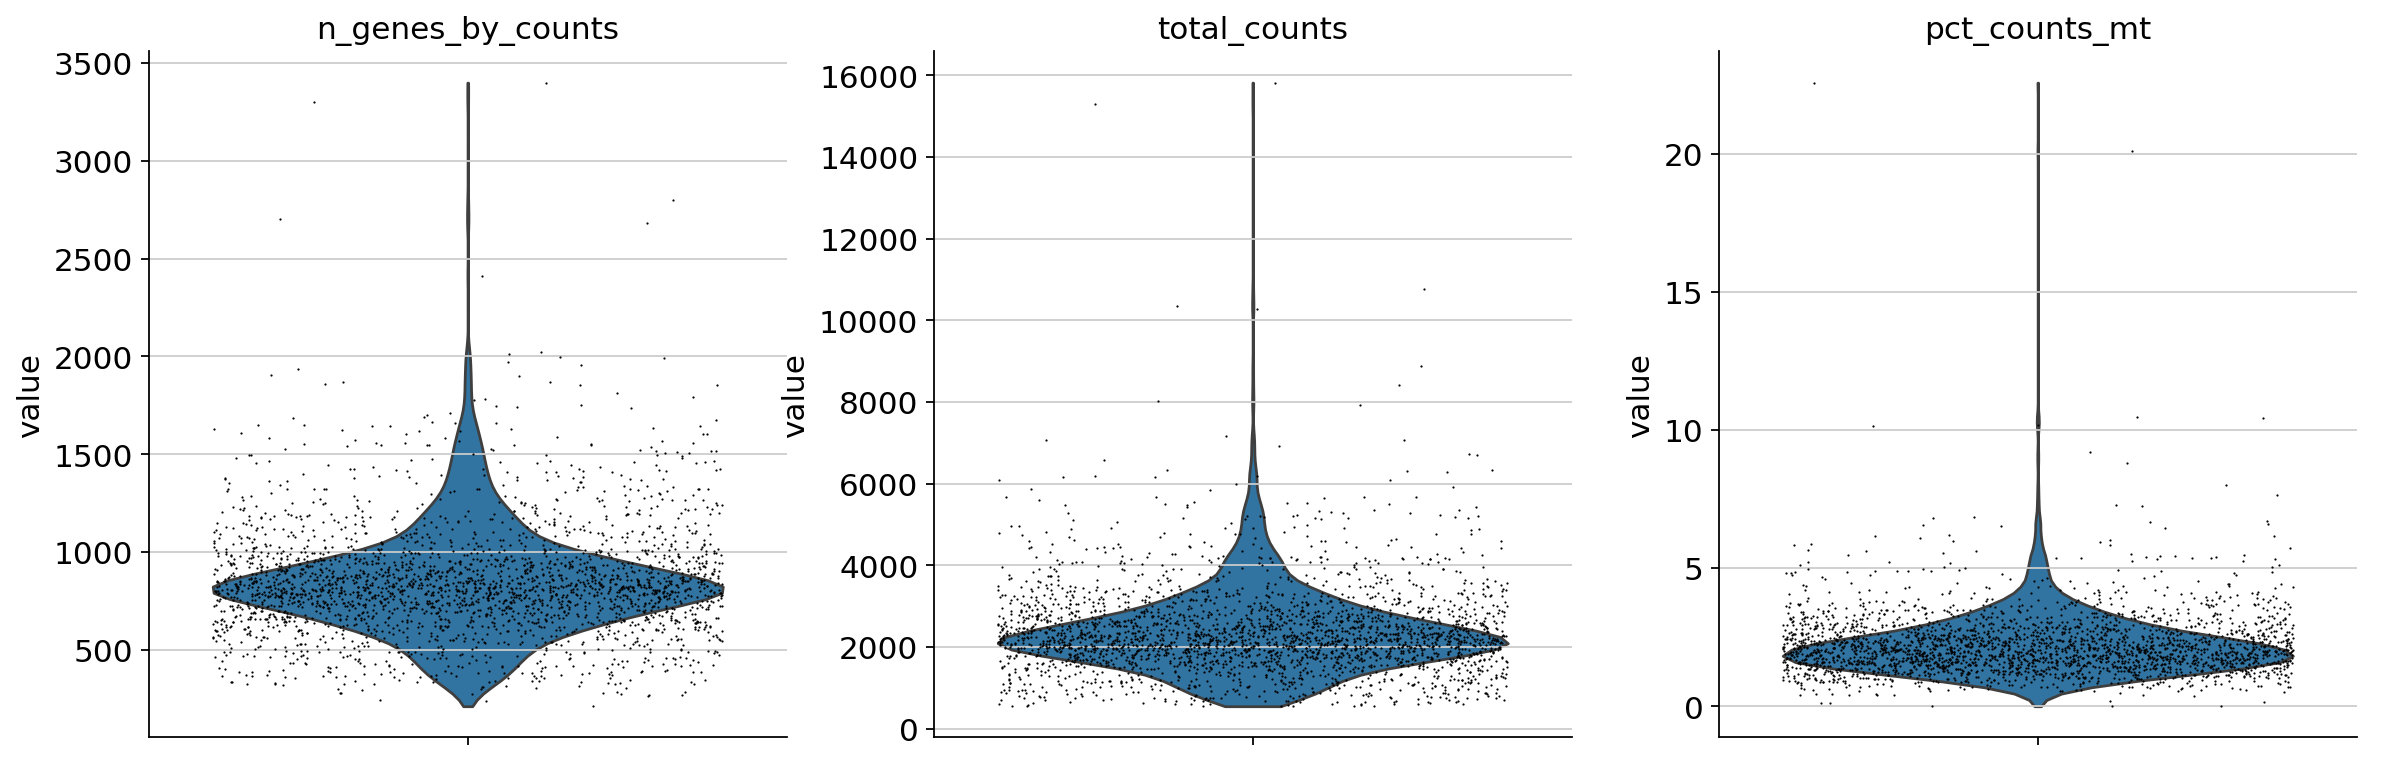

In [23]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

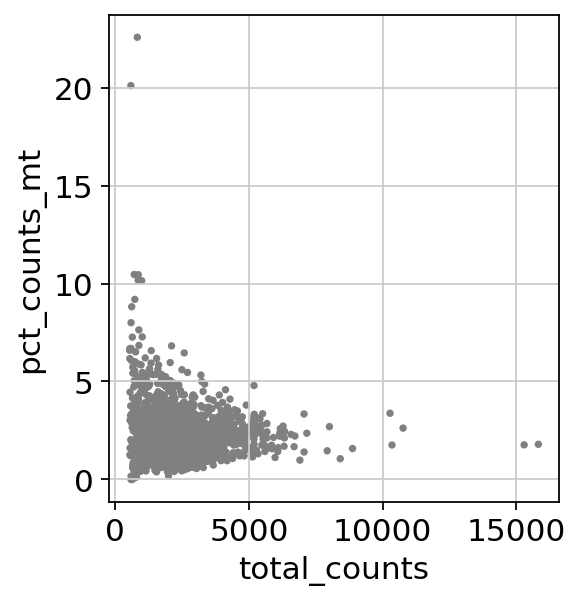

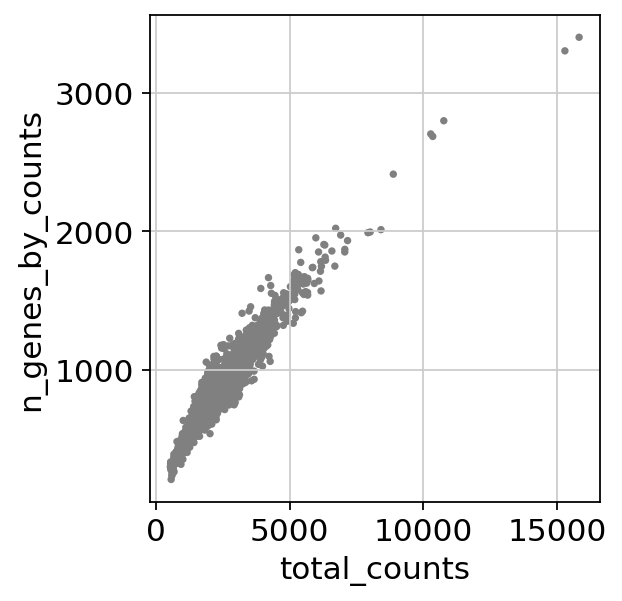

In [24]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

Actually do the filtering by slicing the `AnnData` object.

In [25]:
# 遺伝子カウントが2500以上のものを除く
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# 検出遺伝子に対してミトコンドリアカウントが5%以上のものを除く
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [26]:
# ノーマライゼーション
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [27]:
# ログ変換
sc.pp.log1p(adata)

高変動遺伝子を検出する。

Identify highly-variable genes.

In [28]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


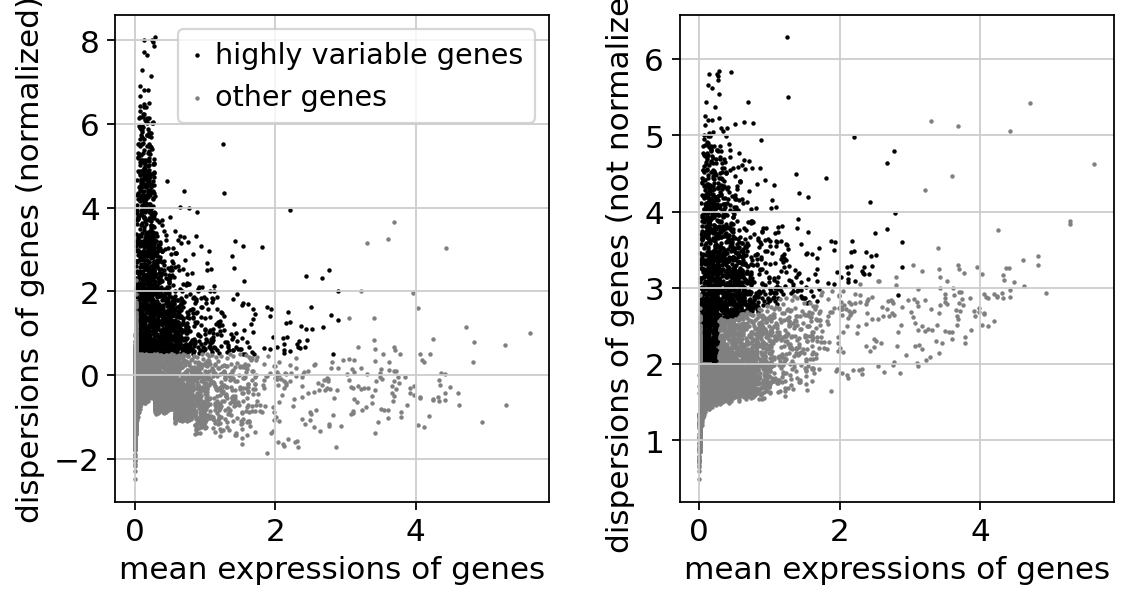

In [29]:
sc.pl.highly_variable_genes(adata)

次元削減などの計算には全部の遺伝子を用いずに、高変動遺伝子(Highly variable genes)のみを用いる。そのため、次元削減などを行う前にデータから高変動遺伝子以外を除く作業を行う。またスケール変換などの操作も行う。しかし、後の下流解析で使用できるために、削除前＆変換前のデータを残しておく。この格納場所として、AnnDataオブジェクトでは`.raw`を用いる。

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.


You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

In [30]:
# Save gene expression data before gene filtering
adata.raw = adata

注意：以下でhighly variable geneのみを残して遺伝子のフィルタリングを行うが、最近のscanpyのバージョンではhighly variable geneを検出してそのデータのみを利用して時限削減などを行う機能が付いているため、highly variable geneのみを明示的に選択して遺伝子のフィルタリングなどを行わなくても良くなった。

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.


Actually do the filtering

In [31]:
# Check data before gene filtering
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [32]:
# Gene filtering
adata = adata[:, adata.var.highly_variable]

In [33]:
# Check data after filtering
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [34]:
# .raw　にはフィルタリング前の全データが残っている
adata.raw.to_adata()

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [35]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:09)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [36]:
# Scaling
sc.pp.scale(adata, max_value=10)

##4. Principal component analysis (PCA)

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [37]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:05)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

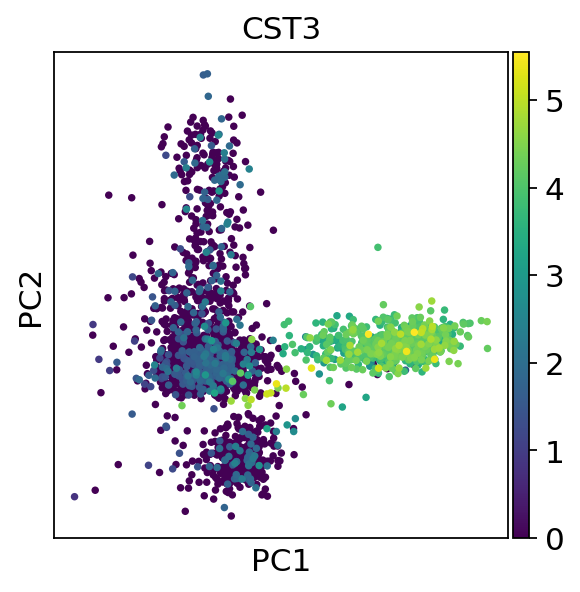

In [38]:
# Check PCA result
sc.pl.pca(adata, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

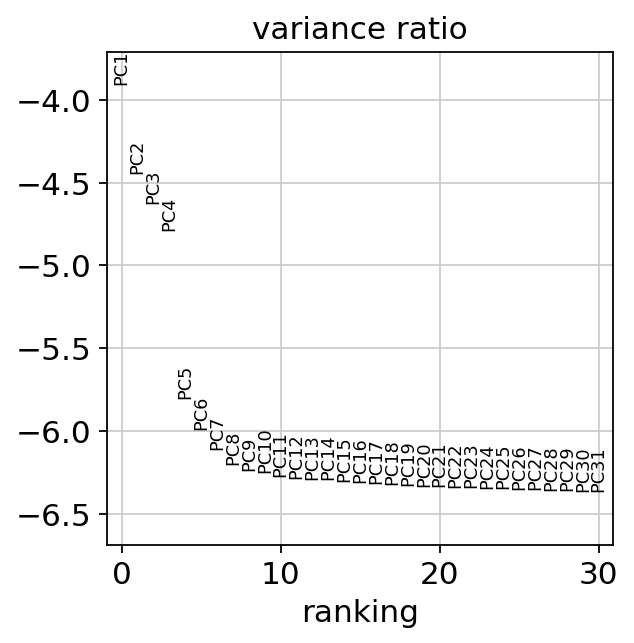

In [39]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [40]:
# ファイルを保存
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results
adata.write(results_file)

In [41]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 5. Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [42]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)



We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.

In [43]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:08)


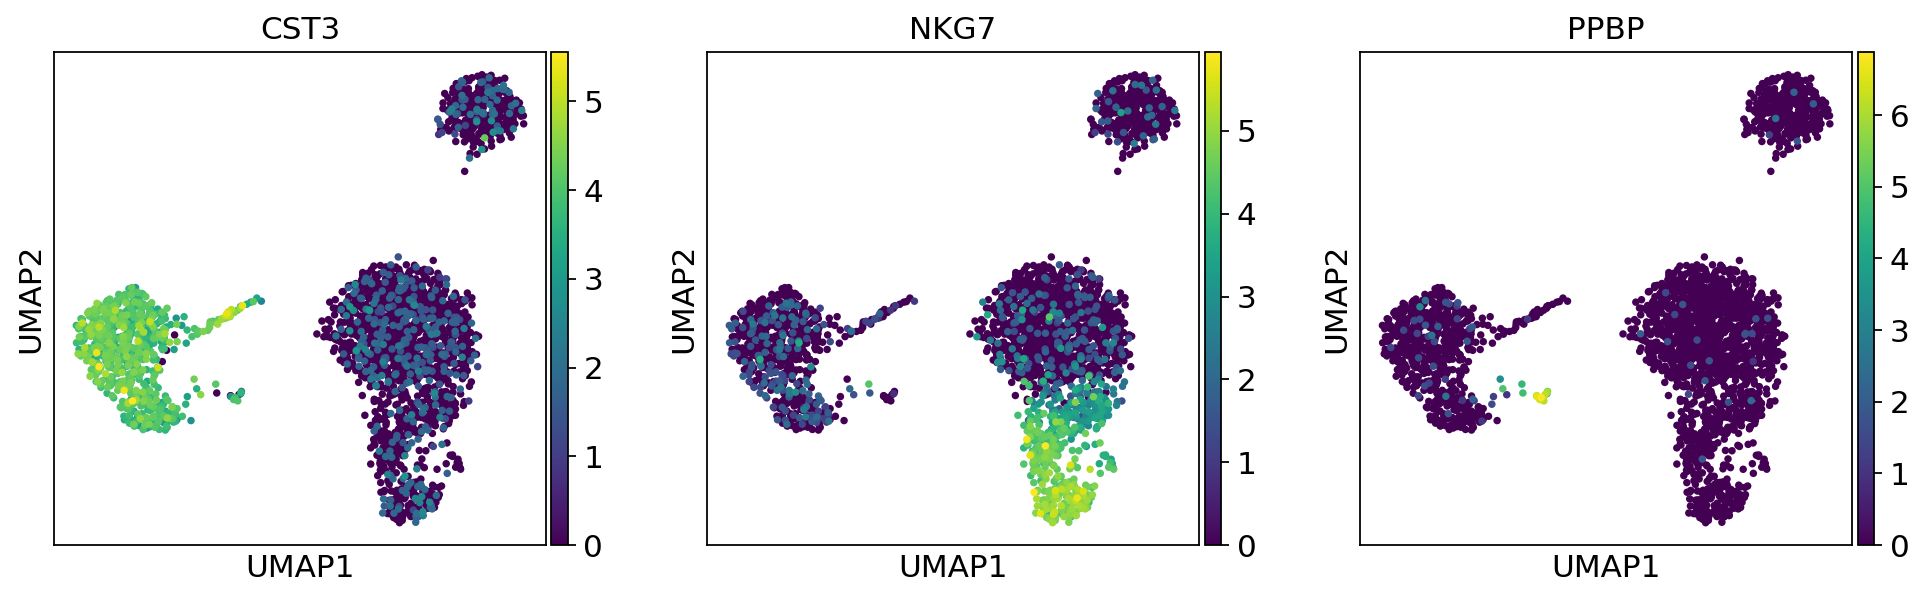

In [44]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

## (オプション)　UMAP 以外のDimensional reduction

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:45)


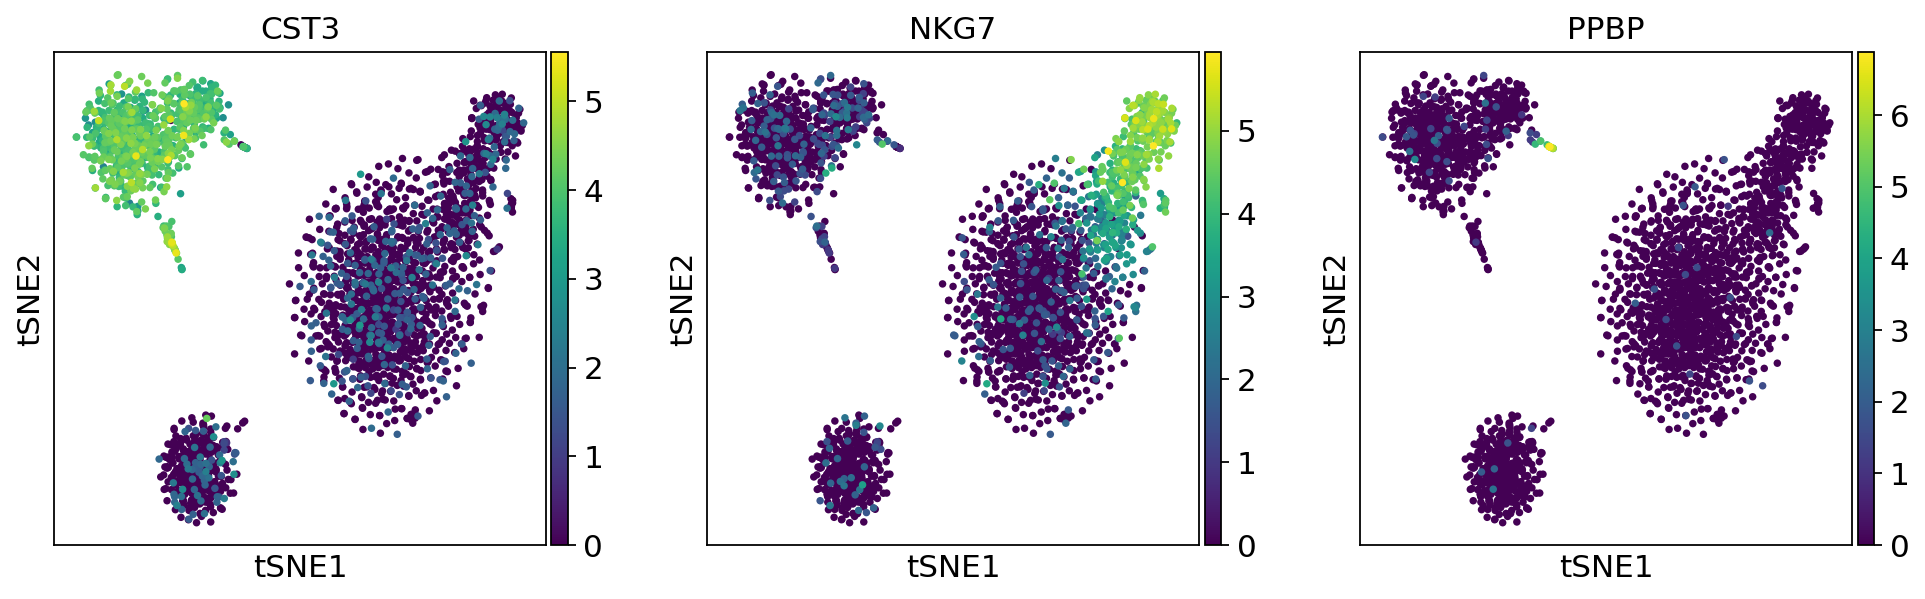

In [45]:
# tSNE
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=["CST3", "NKG7", "PPBP"])

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:24)


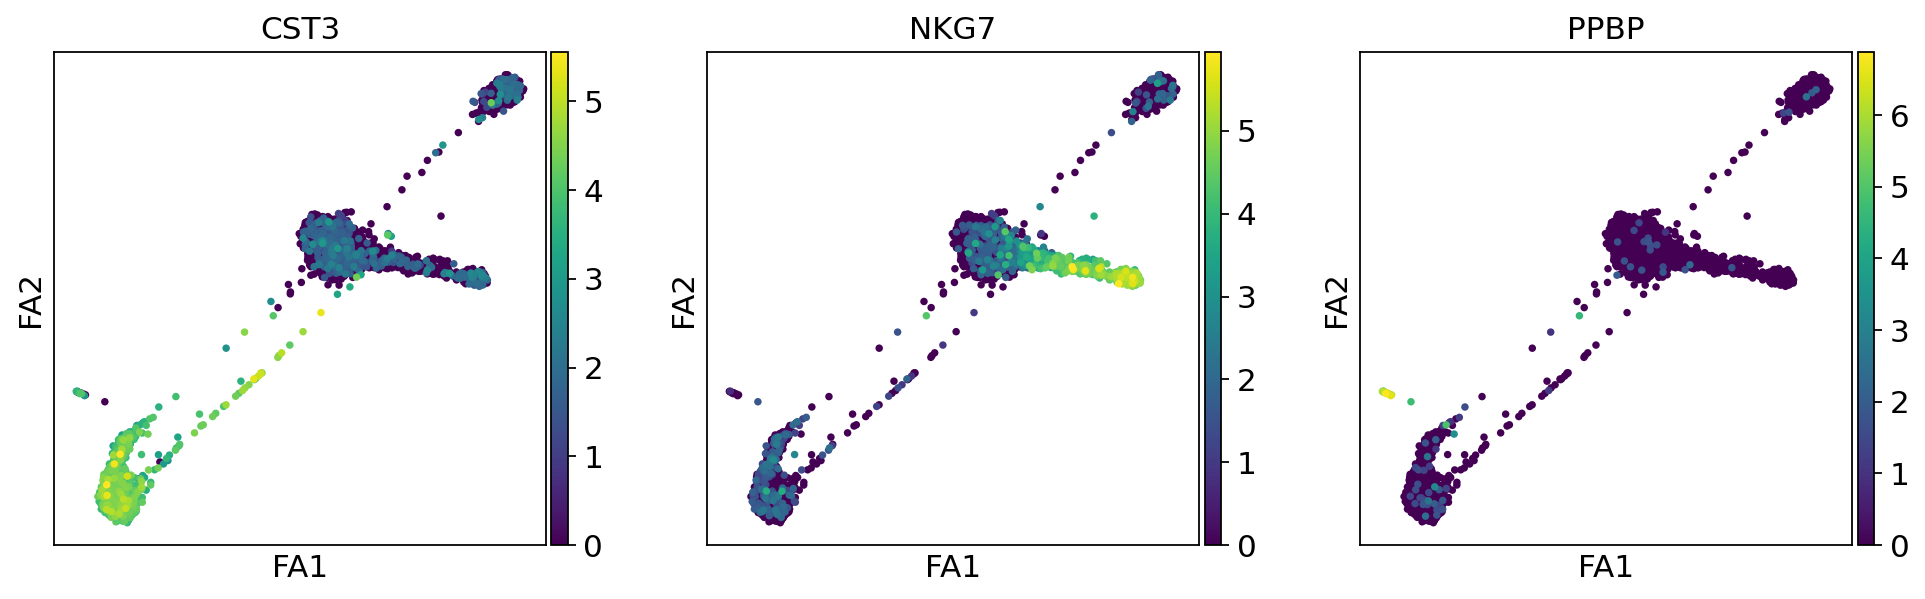

In [46]:
# FA
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=["CST3", "NKG7", "PPBP"])

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9962494  0.9925928  0.9800847  0.9690867  0.95433486
     0.9410094  0.8710743  0.8574797  0.82730544 0.8118933  0.8056505
     0.79537123 0.7825719  0.76136374]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


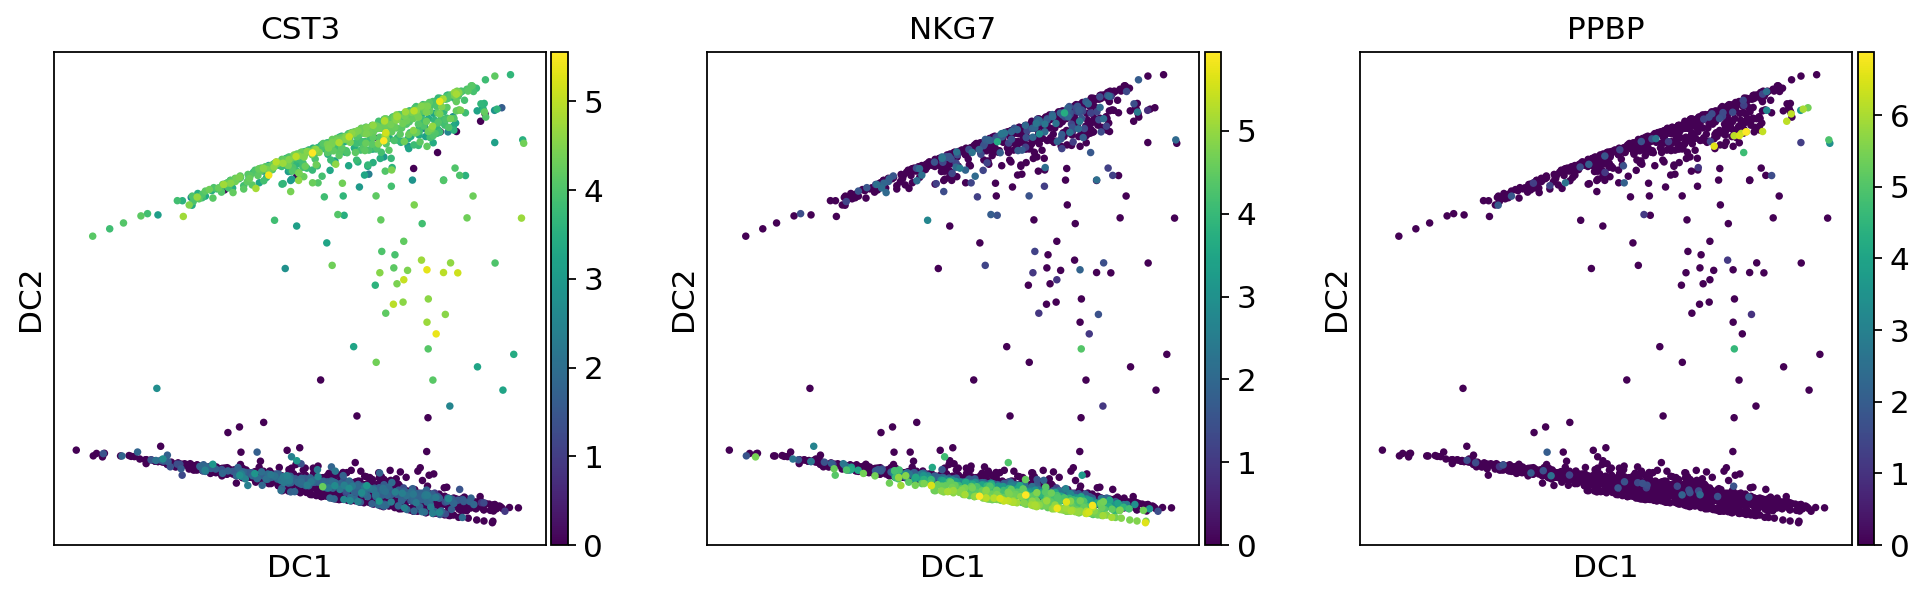

In [47]:
# diffusionmap
sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color=["CST3", "NKG7", "PPBP"])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

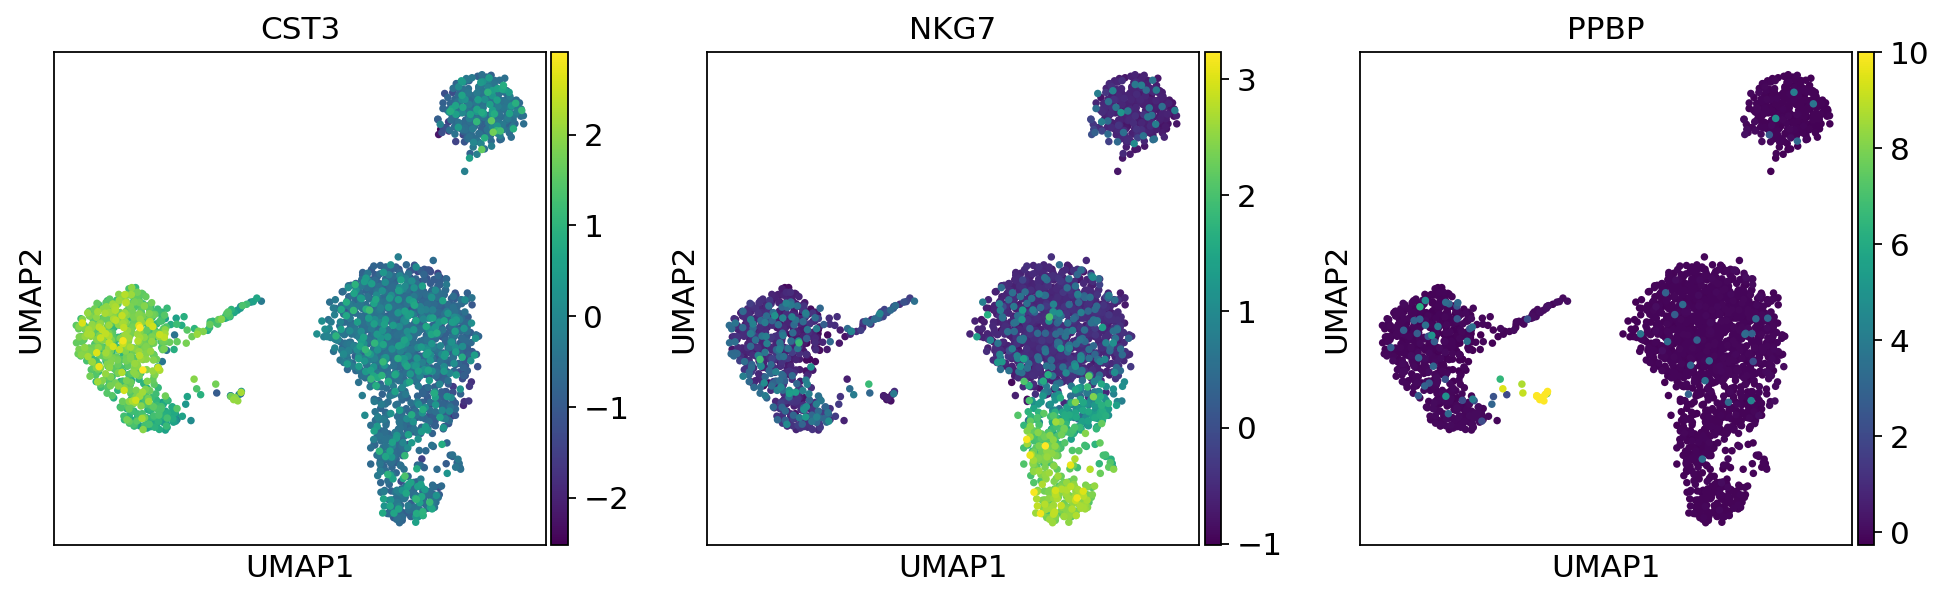

In [48]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

## 6. クラスタリング

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [49]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

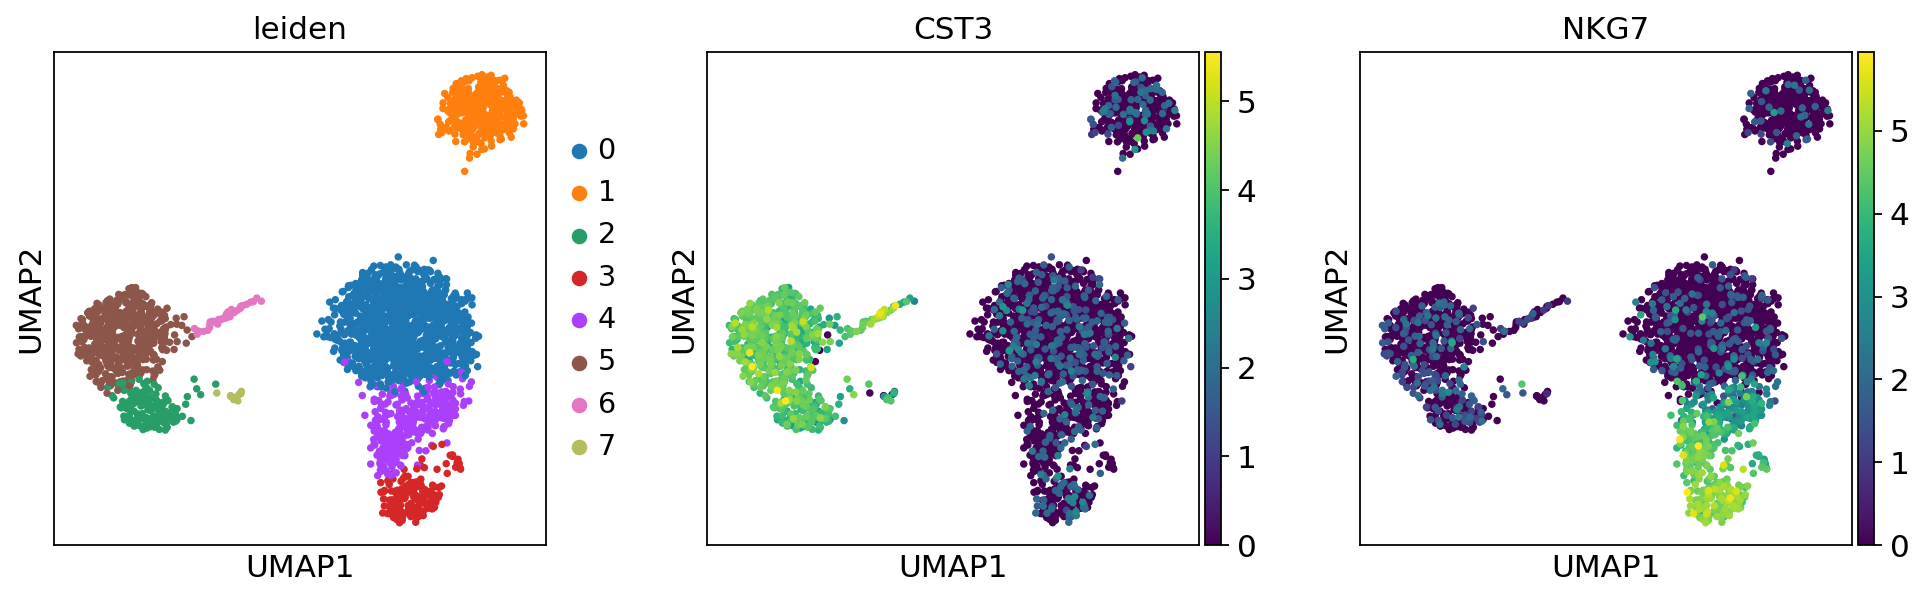

In [50]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

Save the result.

## (オプション）PAGA

https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


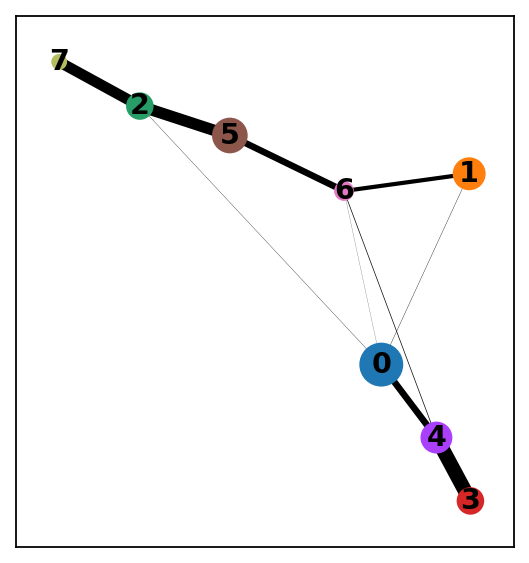

In [51]:
sc.tl.paga(adata)
sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph


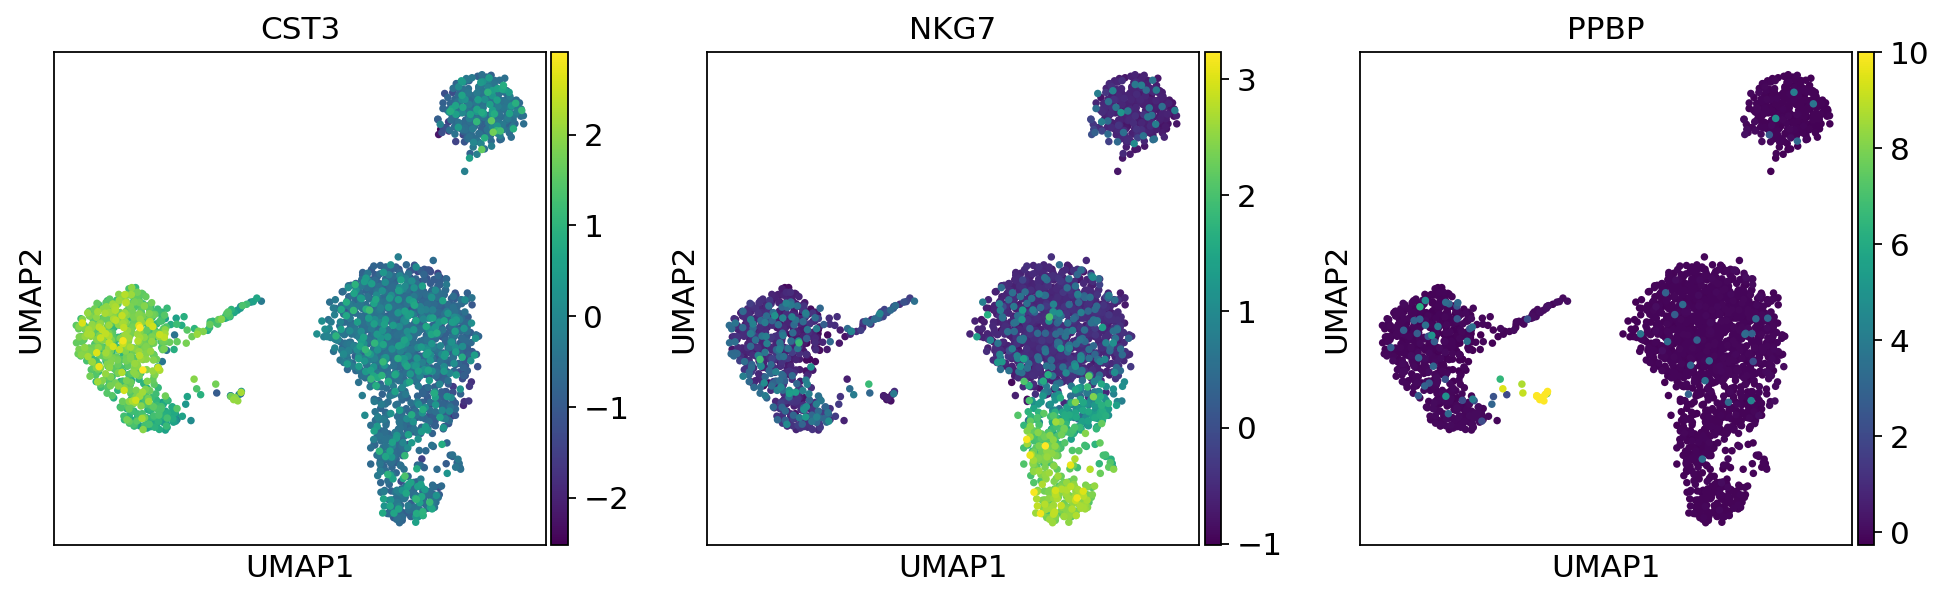

In [52]:
# 前に計算したUMAPを表示
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


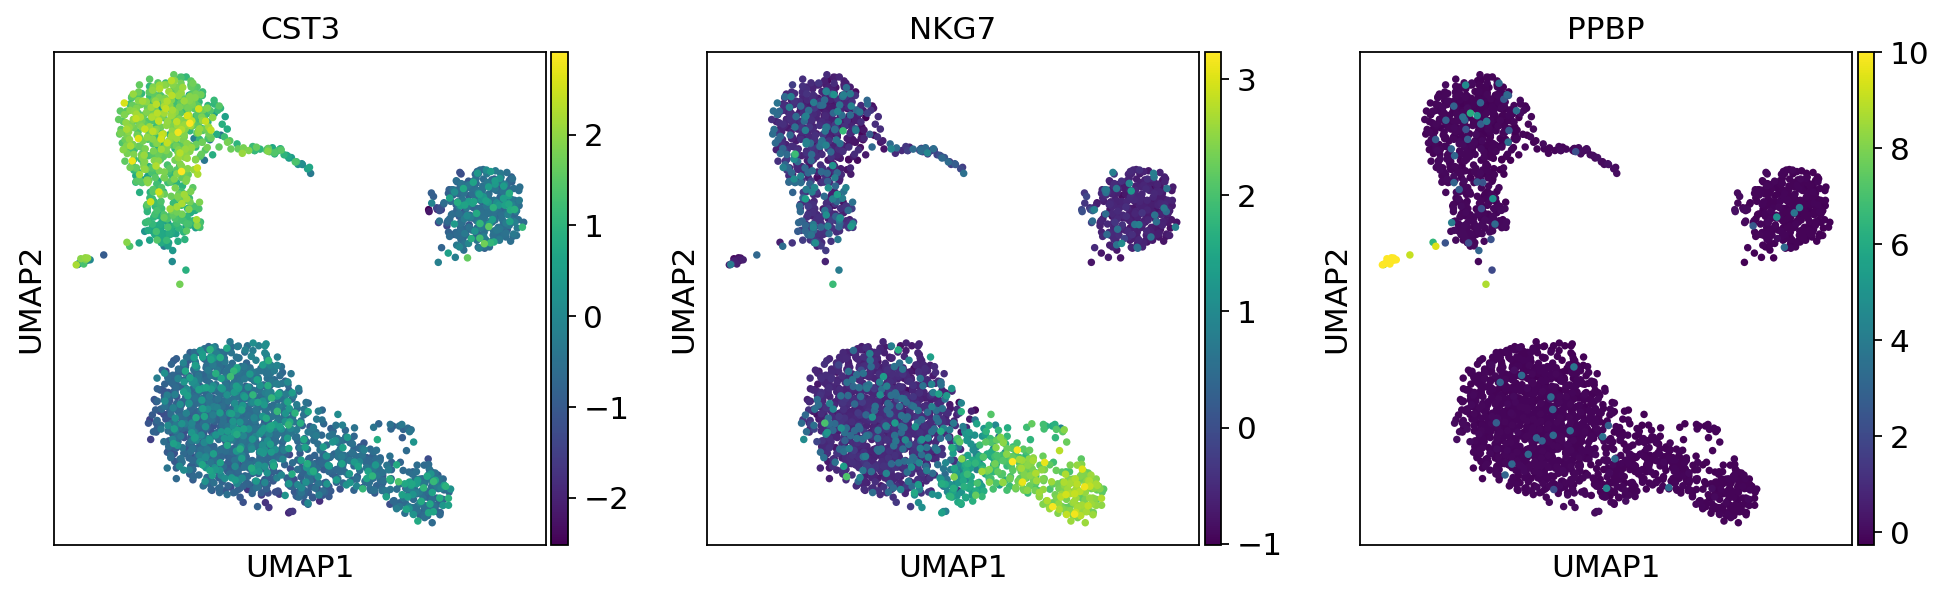

In [53]:
# UMAPの初期値をPAGAを用いて再計算する
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

In [54]:
# ファイルを保存
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results
adata.write(results_file)

## 7. Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


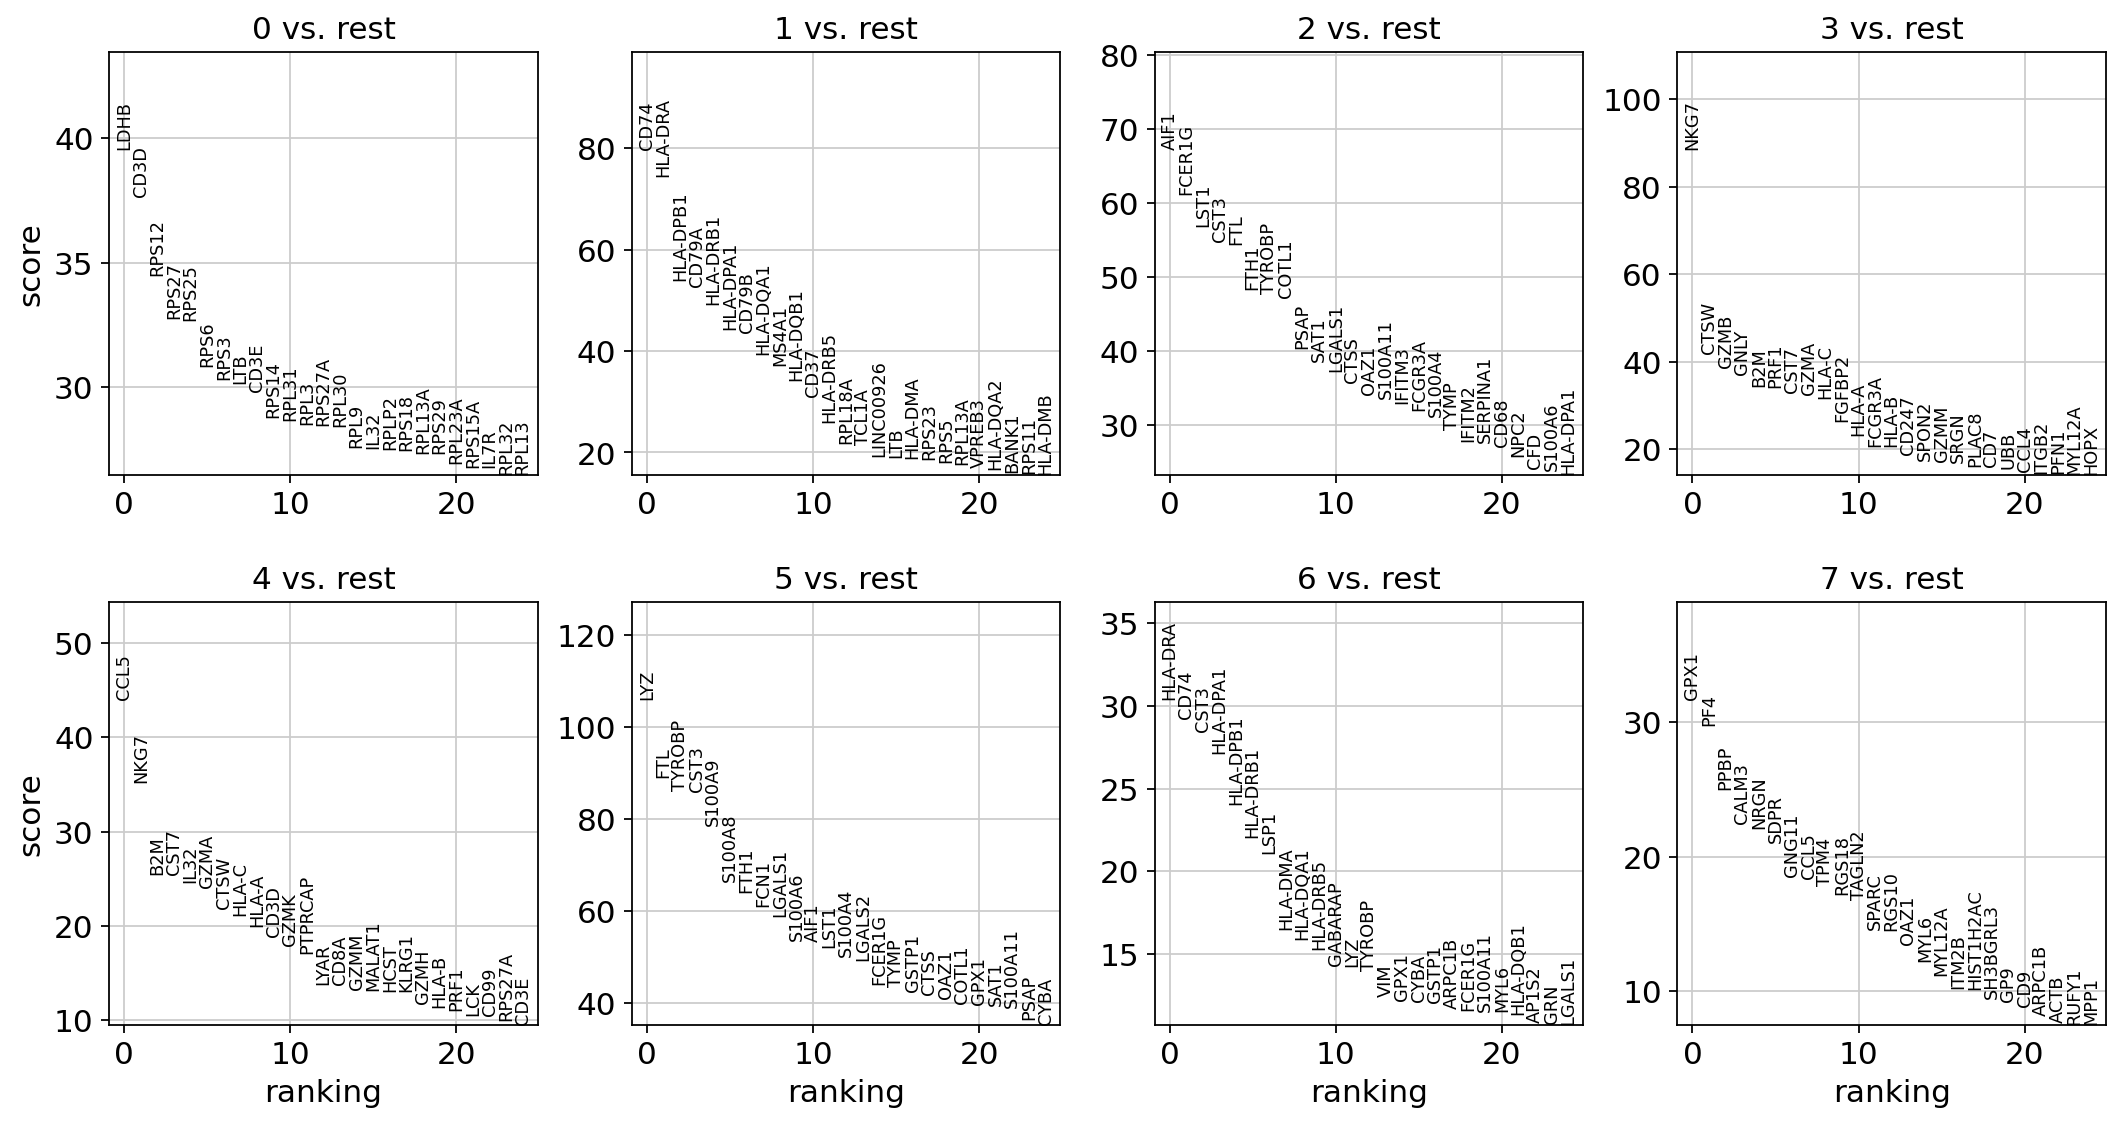

In [55]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [56]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:07)


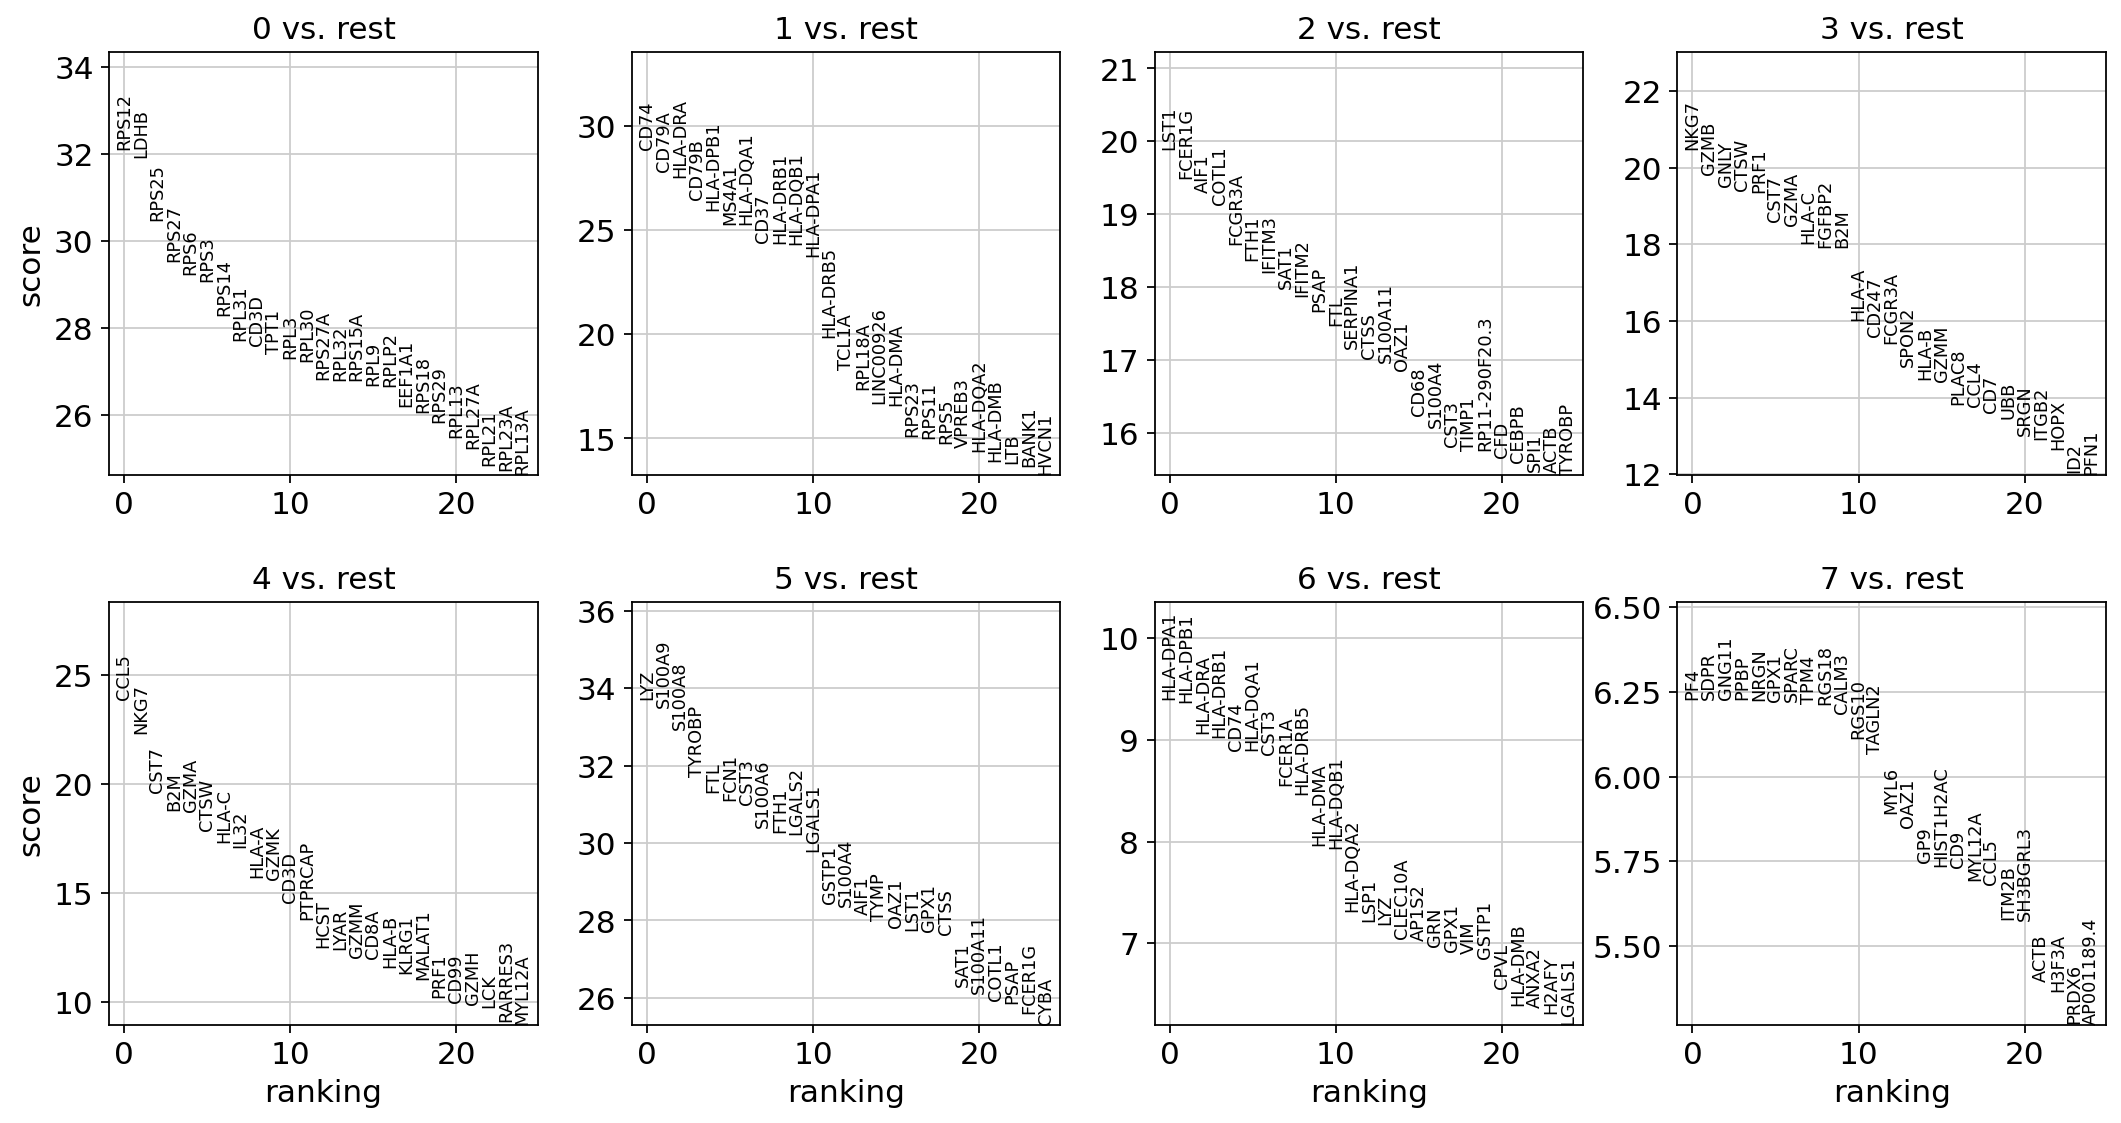

In [57]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [58]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:11)


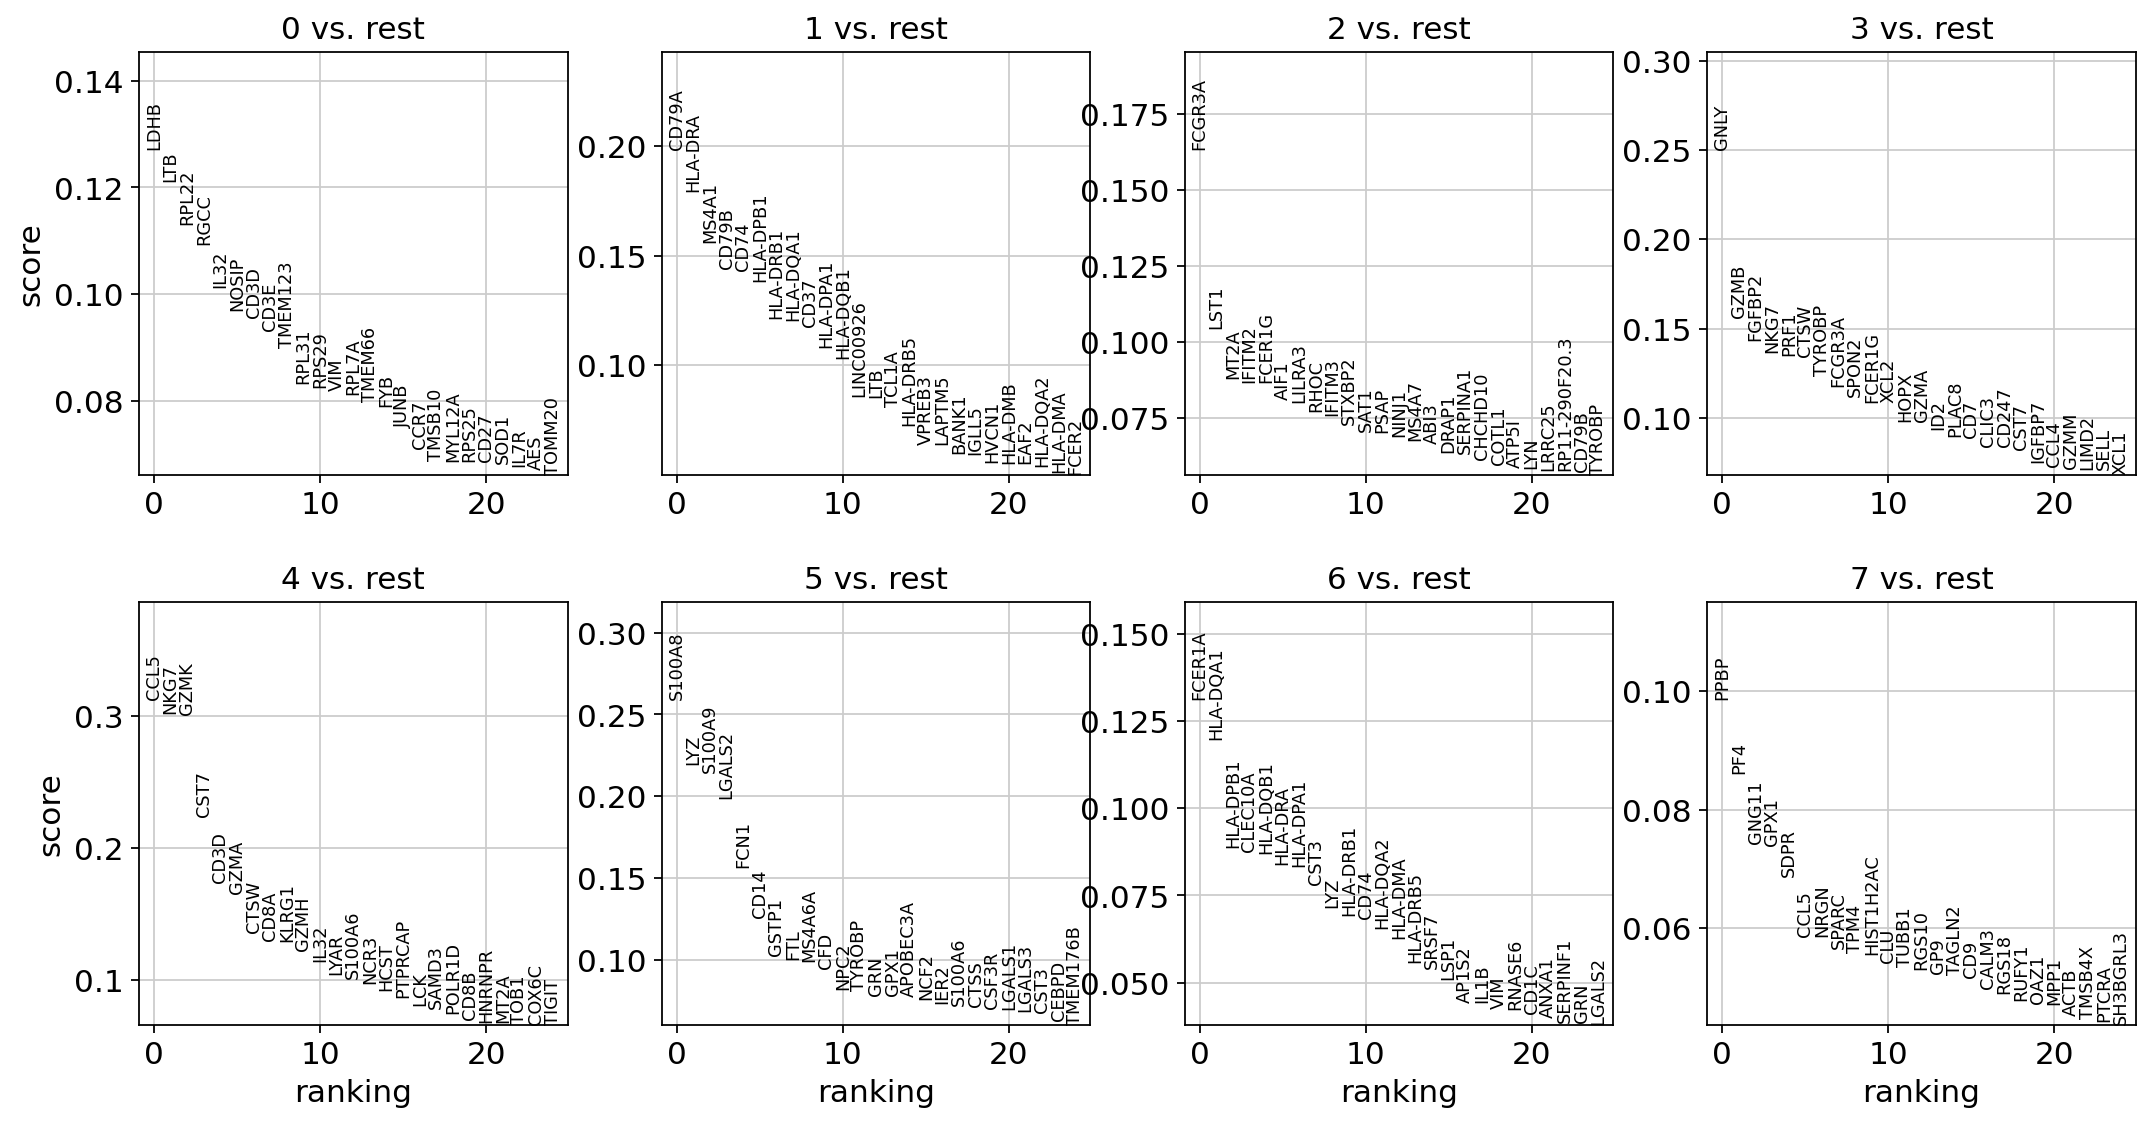

In [59]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [60]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
marker_genes

['IL7R',
 'CD79A',
 'MS4A1',
 'CD8A',
 'CD8B',
 'LYZ',
 'CD14',
 'LGALS3',
 'S100A8',
 'GNLY',
 'NKG7',
 'KLRB1',
 'FCGR3A',
 'MS4A7',
 'FCER1A',
 'CST3',
 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [61]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [62]:
adata.uns["rank_genes_groups"]["names"]

array([('RPS12', 'CD74', 'LST1', 'NKG7', 'CCL5', 'LYZ', 'HLA-DPA1', 'PF4'),
       ('LDHB', 'CD79A', 'FCER1G', 'GZMB', 'NKG7', 'S100A9', 'HLA-DPB1', 'SDPR'),
       ('RPS25', 'HLA-DRA', 'AIF1', 'GNLY', 'CST7', 'S100A8', 'HLA-DRA', 'GNG11'),
       ...,
       ('HLA-DRA', 'S100A6', 'RPL13A', 'RPL28', 'RPS11', 'RPS27', 'RPL21', 'RPL11'),
       ('CYBA', 'TMSB4X', 'RPL3', 'RPL18A', 'FTH1', 'RPS27A', 'RPS27', 'MALAT1'),
       ('CD74', 'S100A4', 'RPL13', 'RPL32', 'TMSB10', 'MALAT1', 'MALAT1', 'RPL10')],
      dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')])

In [63]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

0         1       2       3        4       5         6       7
0         RPS12      CD74    LST1    NKG7     CCL5     LYZ  HLA-DPA1     PF4
1          LDHB     CD79A  FCER1G    GZMB     NKG7  S100A9  HLA-DPB1    SDPR
2         RPS25   HLA-DRA    AIF1    GNLY     CST7  S100A8   HLA-DRA   GNG11
3         RPS27     CD79B   COTL1    CTSW      B2M  TYROBP  HLA-DRB1    PPBP
4          RPS6  HLA-DPB1  FCGR3A    PRF1     GZMA     FTL      CD74    NRGN
...         ...       ...     ...     ...      ...     ...       ...     ...
13709  HLA-DPB1      IL32   RPS18   RPL11     CTSS    RPSA       B2M    RPL3
13710  HLA-DRB1     ANXA1    RPS3   RPL13  HLA-DRA  RPL23A      BTG1   RPL29
13711   HLA-DRA    S100A6  RPL13A   RPL28    RPS11   RPS27     RPL21   RPL11
13712      CYBA    TMSB4X    RPL3  RPL18A     FTH1  RPS27A     RPS27  MALAT1
13713      CD74    S100A4   RPL13   RPL32   TMSB10  MALAT1    MALAT1   RPL10

[13714 rows x 8 columns]

In [64]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0         1       2     3     4       5         6      7
0  RPS12      CD74    LST1  NKG7  CCL5     LYZ  HLA-DPA1    PF4
1   LDHB     CD79A  FCER1G  GZMB  NKG7  S100A9  HLA-DPB1   SDPR
2  RPS25   HLA-DRA    AIF1  GNLY  CST7  S100A8   HLA-DRA  GNG11
3  RPS27     CD79B   COTL1  CTSW   B2M  TYROBP  HLA-DRB1   PPBP
4   RPS6  HLA-DPB1  FCGR3A  PRF1  GZMA     FTL      CD74   NRGN

Get a table with the scores and groups.

In [65]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n            0_p       1_n            1_p     2_n           2_p   3_n  \
0  RPS12  4.167598e-226      CD74  2.487145e-183    LST1  4.985426e-88  NKG7   
1   LDHB  1.794807e-223     CD79A  1.679730e-170  FCER1G  1.449472e-84  GZMB   
2  RPS25  4.659461e-204   HLA-DRA  6.935111e-167    AIF1  5.833547e-83  GNLY   
3  RPS27  9.438482e-192     CD79B  2.569135e-154   COTL1  1.261406e-81  CTSW   
4   RPS6  5.767118e-188  HLA-DPB1  3.577195e-148  FCGR3A  4.610698e-77  PRF1   

            3_p   4_n            4_p     5_n            5_p       6_n  \
0  3.591782e-93  CCL5  4.062586e-126     LYZ  2.844372e-249  HLA-DPA1   
1  2.033412e-87  NKG7  1.528118e-110  S100A9  2.654880e-246  HLA-DPB1   
2  8.130223e-85  CST7   1.332168e-85  S100A8  8.731315e-238   HLA-DRA   
3  6.944632e-84   B2M   8.615108e-79  TYROBP  9.809633e-221  HLA-DRB1   
4  1.621421e-83  GZMA   1.480430e-78     FTL  3.676035e-215      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

Compare to a single cluster:

ranking genes
    finished (0:00:02)


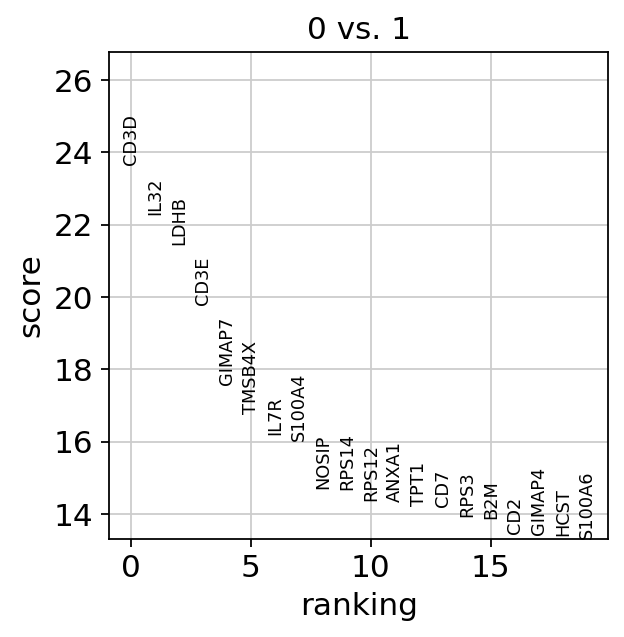

In [66]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


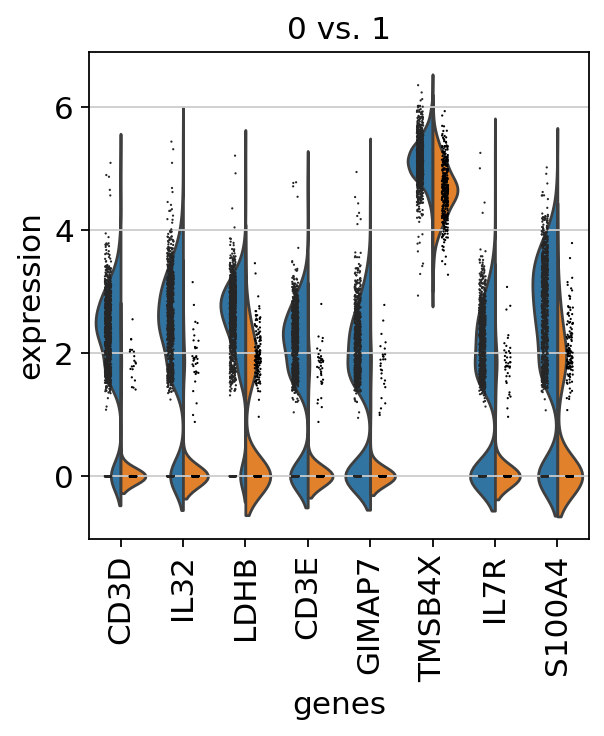

In [67]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [68]:
adata = sc.read(results_file)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


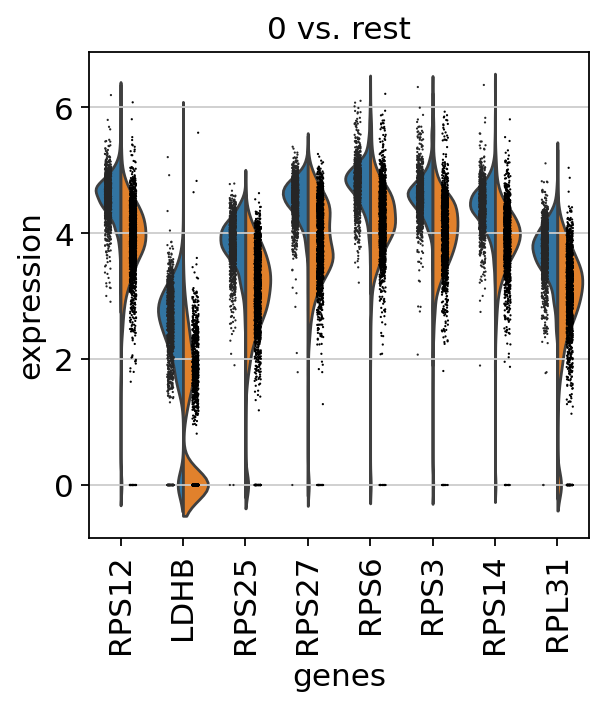

In [69]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

If you want to compare a certain gene across groups, use the following.

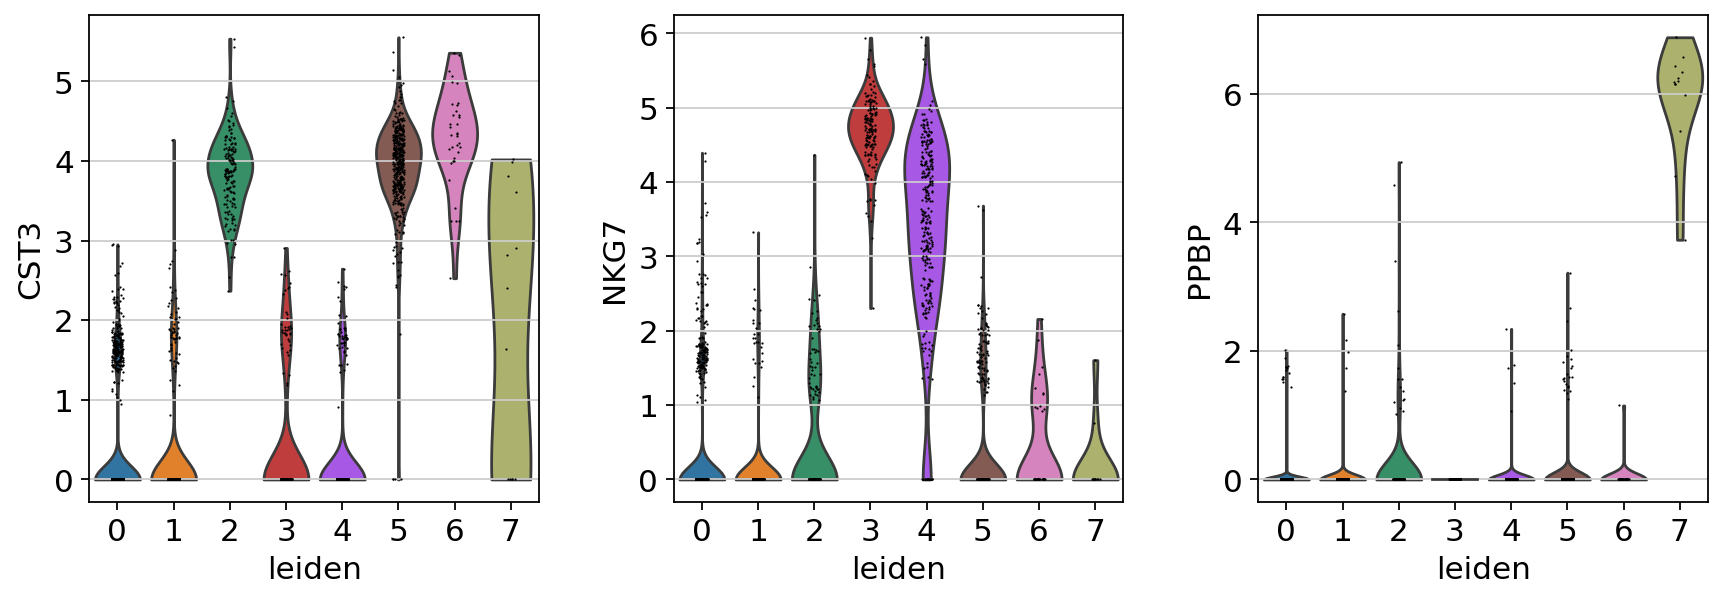

In [70]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

# 8. Cell annotation

先ほど見つけたクラスター毎のマーカー遺伝子や事前知識の遺伝子リストを用いて細胞のアノテーションを行う。

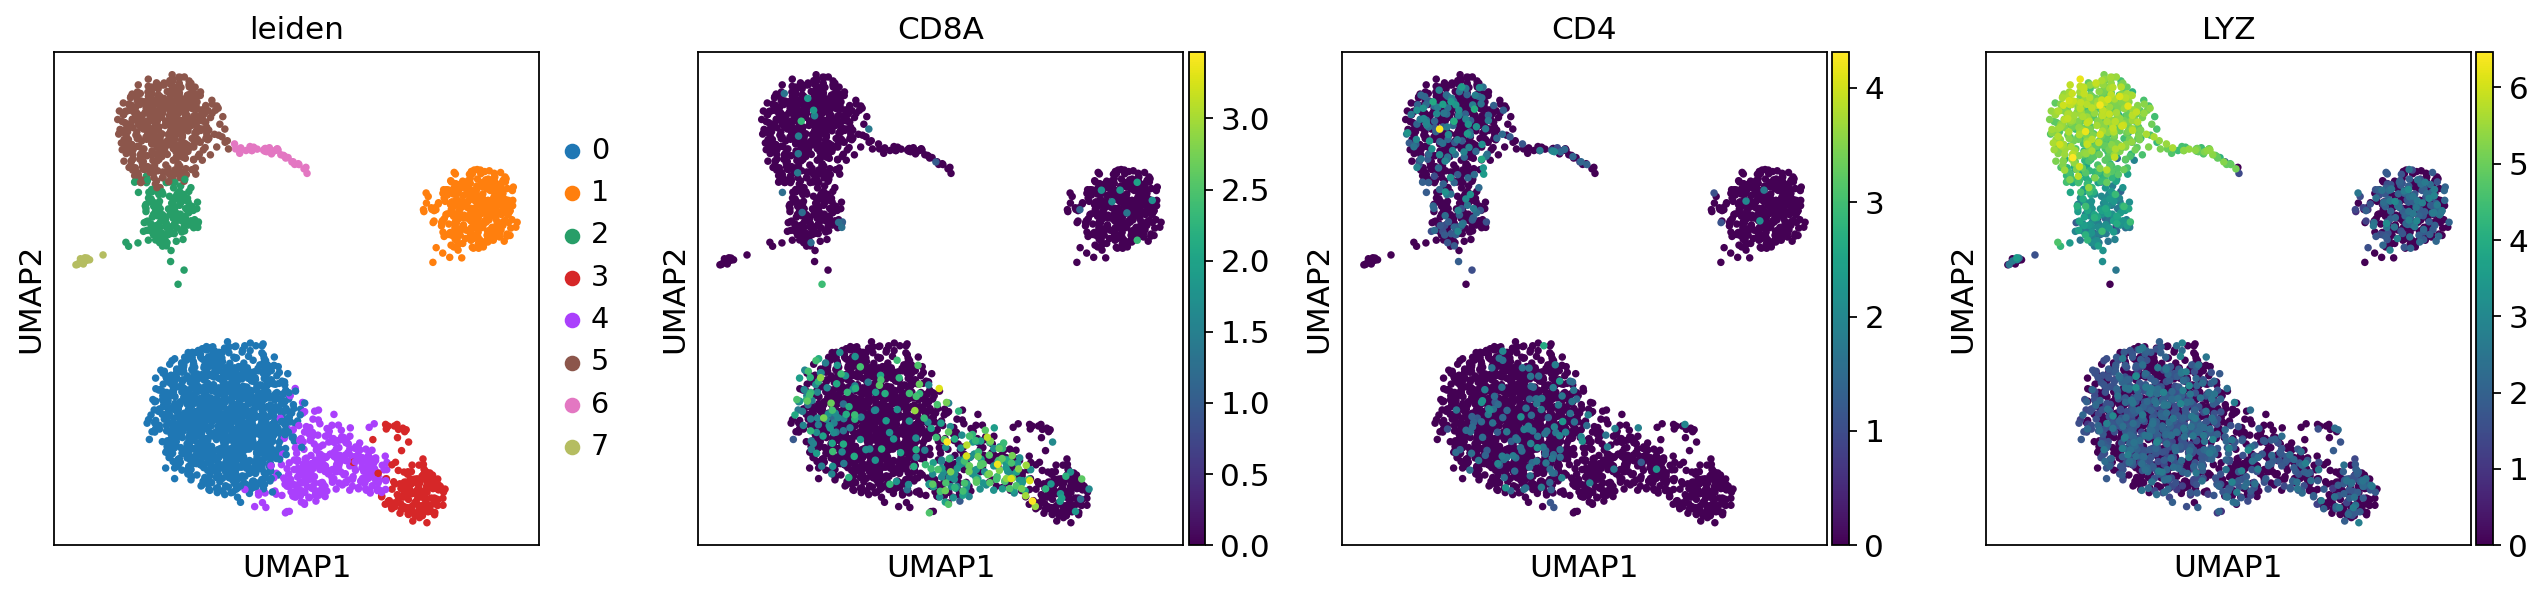

In [71]:
sc.pl.umap(adata, color=["leiden", "CD8A", "CD4", "LYZ"])

In [72]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

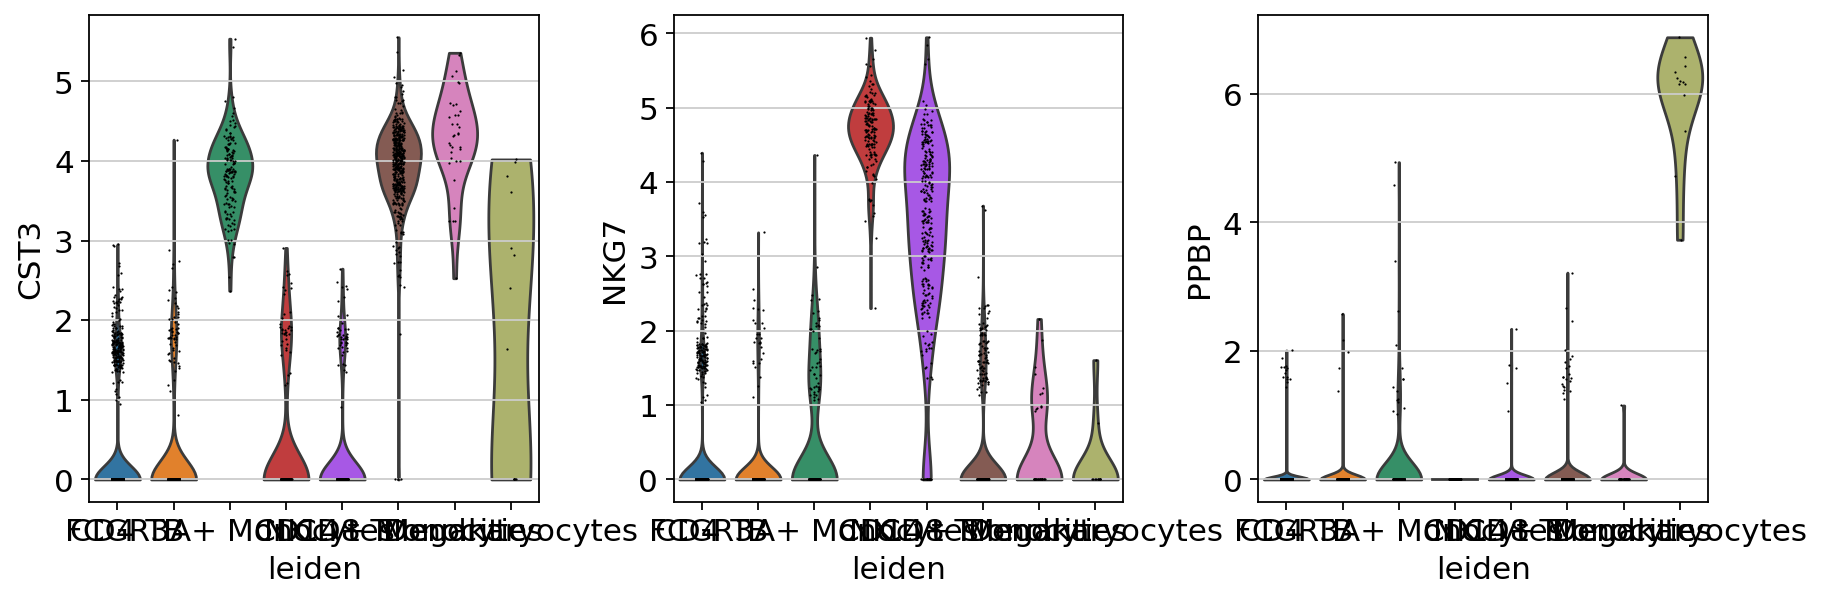

In [73]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [74]:
sc.pl.violin?

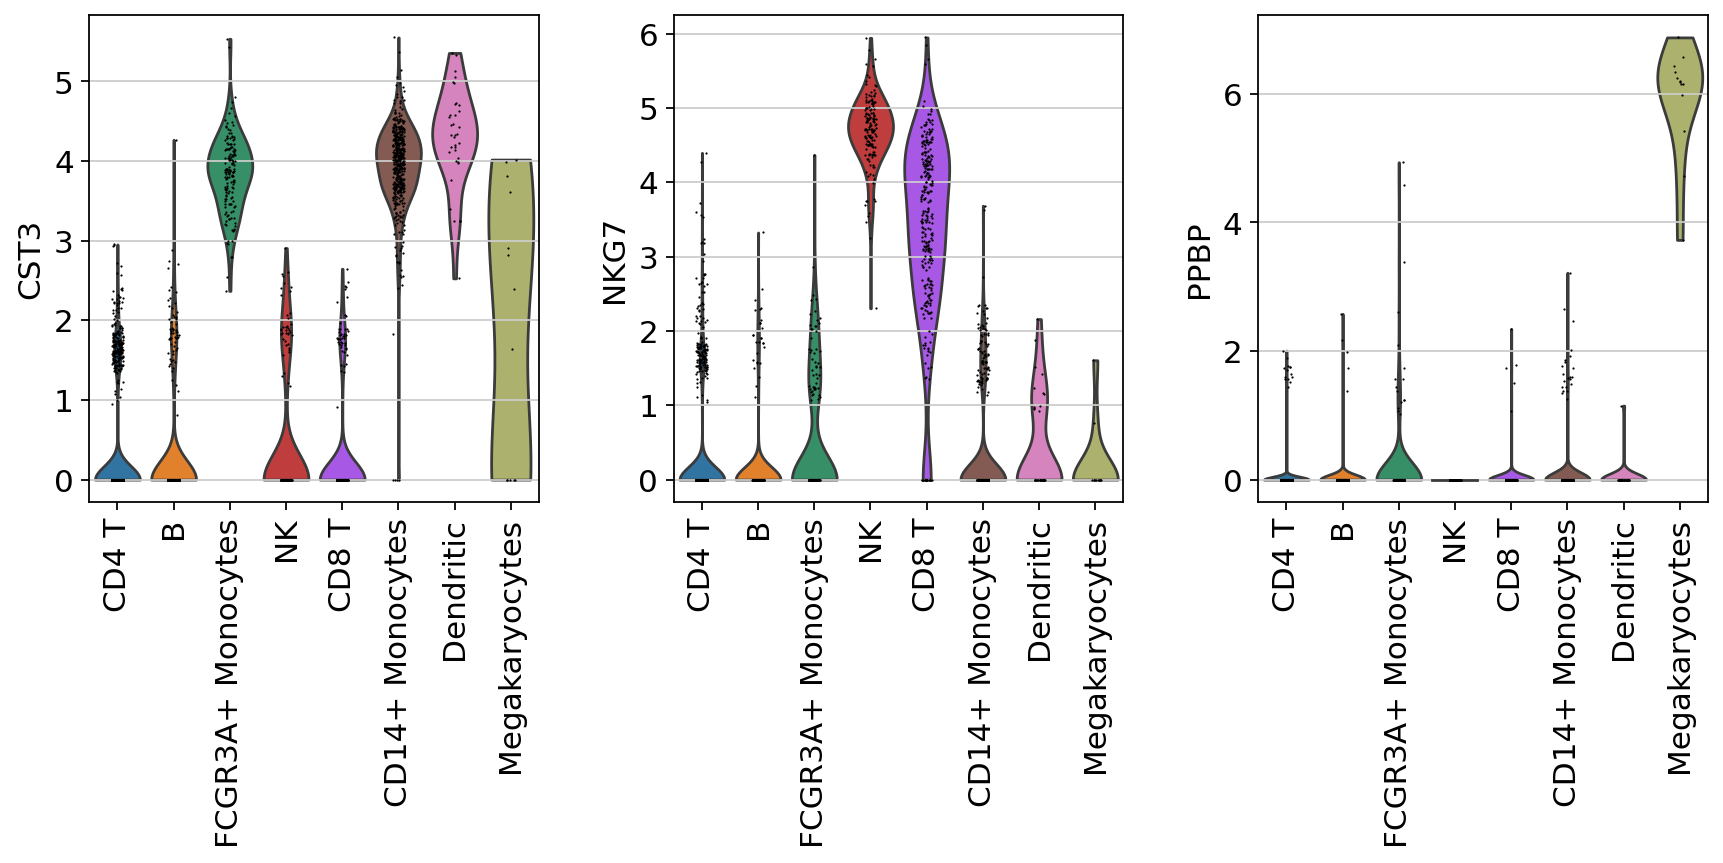

In [75]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden", rotation=90)

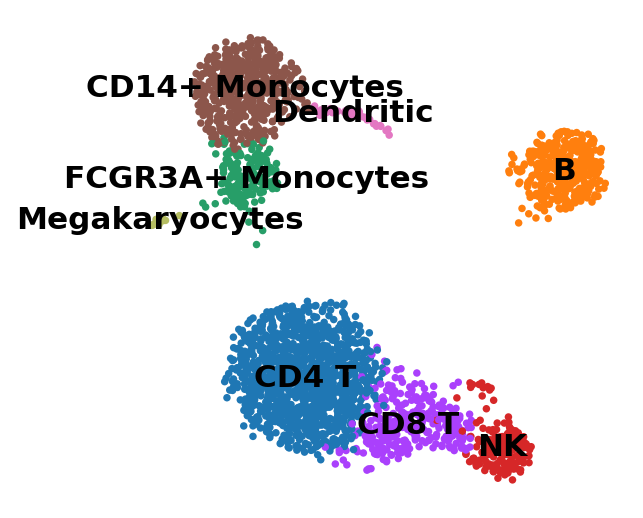

In [76]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False)

In [77]:
sc.pl.umap?

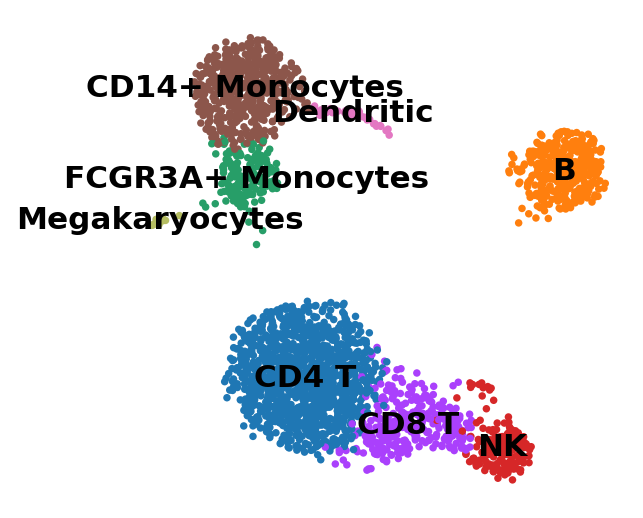

In [78]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

Now that we annotated the cell types, let us visualize the marker genes.

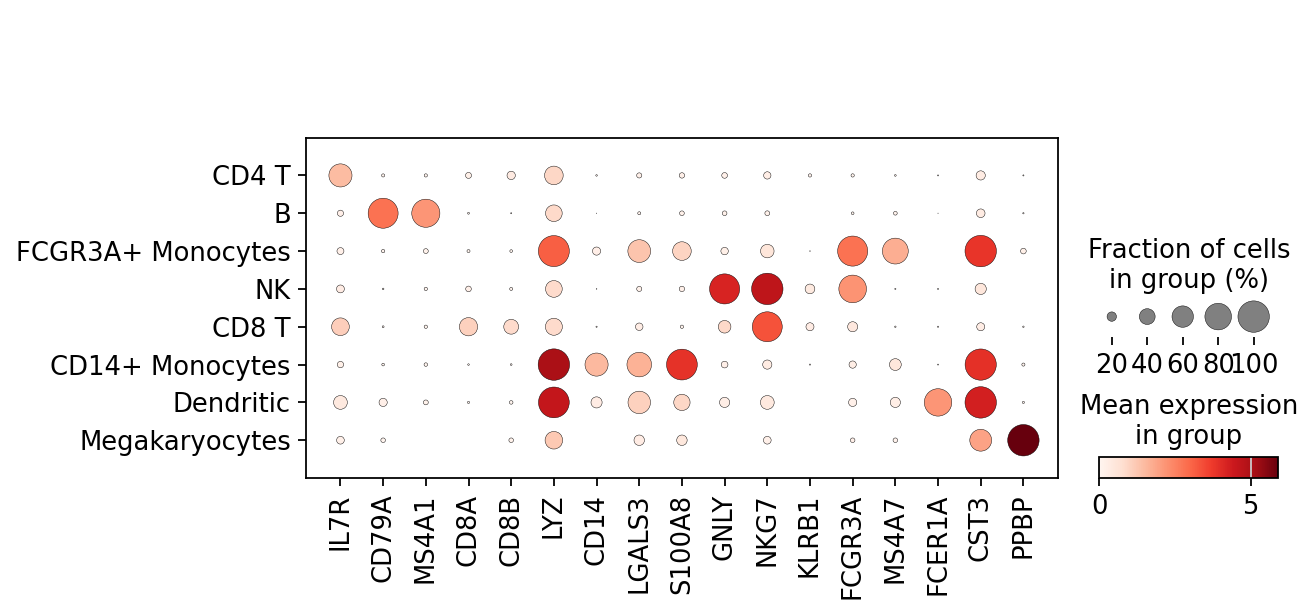

In [79]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

There is also a very compact violin plot.

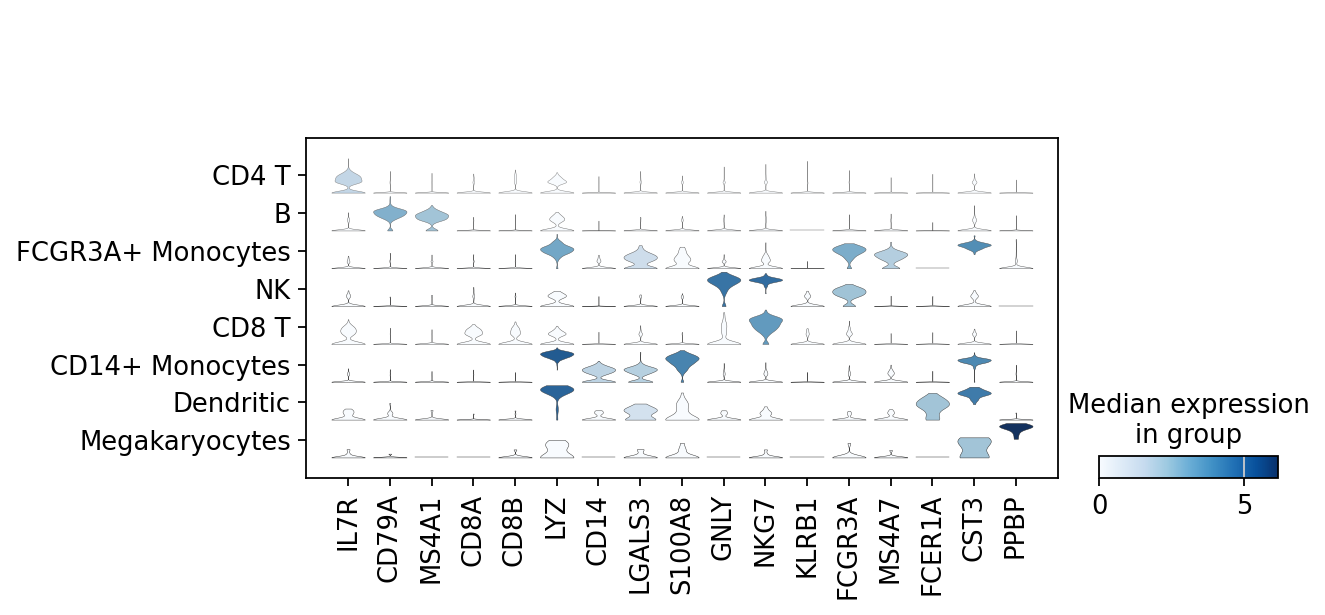

In [80]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

During the course of this analysis, the AnnData accumlated the following annotations.

In [81]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [82]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
results_file = "write/pbmc3k.h5ad"
adata.write(results_file, compression="gzip")

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [83]:
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")